# Methylation analysis

## Initialization 

In [1]:
if (!require("tet.gastru")){
    if (!require("devtools")){
        install.packages("devtools")
    }
    devtools::install(here("scripts/tet.gastru"))
}
library(tet.gastru)
init()

Loading required package: tet.gastru

here() starts at /net/mraid14/export/tgdata/users/aviezerl/proj/tetchim/tet-gastrulation



## Define genomic contexts

#### CTCF motif

In [2]:
gvtrack.create("ctcf", "ctcf_motif", "global.percentile.max")

#### CpG islands

In [3]:
cgi_intervs <- gintervals.load("intervs.global.cpgIsland")

#### Time of replication (TOR)

In [4]:
gvtrack.create("tor", "Encode.esd3.replichip.rep2", "avg")    
gvtrack.iterator("tor", sshift=-15000, eshift=15000)

#### K4me3/K27me3 peaks

Due to the large size of the ENCODE tracks which generated the CHIP peaks, we supply here also the result of our computation. You can see the details at: `scripts/tet.gastru/R/genomic-context.R`

* `define_k4me3_peaks()`
* `define_k27me_peaks()`
* `define_atac_peaks()`

In a nutshell - we aggregate functional annotation using data from ENCODE (Bing Ren's lab), and from the following paper: 

Xiang, Y., Zhang, Y., Xu, Q. et al. Epigenomic analysis of gastrulation identifies a unique chromatin state for primed pluripotency. Nat Genet 52, 95–105 (2020). https://doi.org/10.1038/s41588-019-0545-1


In [5]:
k4me3_peaks <- fread(here("data/k4me3_peaks.tsv"))
k27me3_peaks <- fread(here("data/k27me3_peaks.tsv"))
atac_peaks <- fread(here("data/atac_peaks.tsv"))

#### Local 'dips' in methylation 

A local reduction in methylation can be an indicator for a functional element (e.g. enhancer). We screen for such regions at methylation of e8.5:

In [6]:
meth_dips <- meth_dip_screen("e8_5", dip_size=300, flank_size=500, margin=50, min_diff=0.4, min_cov=50, ret_values=TRUE) %cache_df% here("output/e8.5_dips.tsv") %>% as_tibble()

## Extract methylation data 

We will start by extracting all methylation data:

### All CpGs

We extract methylation in smoothed over 200bp from each side of the CpG, and not smoothed:

In [7]:
meth_df_comp <- gextract_meth(
    c(comb_tracks, 
      "e8_5", 
      "Zhang_Nature_Genetics_2017.Ect_mCG", 
      "Zhang_Nature_Genetics_2017.End_mCG", 
      "Zhang_Nature_Genetics_2017.Mes_mCG", 
      "Zhang_Nature_Genetics_2017.E65Epi_mCG"), 
    names=c(comb_names, "e8.5", "ecto", "endo", "meso", "epi"), 
    extract_meth_calls=TRUE, 
    d_expand=200, 
    annot_tracks = "ctcf") %>% 
    mutate(e7.5.meth = ecto.meth + endo.meth + meso.meth, e7.5.cov = ecto.cov + endo.cov + meso.cov, e7.5 = e7.5.meth / e7.5.cov) %cache_df%
    here("output/cpg_meth_expand_200_comp.tsv") %>% 
    as_tibble()
nrow(meth_df_comp)
head(meth_df_comp)

[1] 21342750

chrom,start,end,ctrl,tet_tko,e8.5,ecto,endo,meso,epi,⋯,e8.5.meth,ecto.meth,endo.meth,meso.meth,epi.meth,ctcf,intervalID,e7.5.meth,e7.5.cov,e7.5
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>
chr1,3000573,3000574,1.0000000,0.8333333,0.6666667,0.7333333,0.4583333,0.7600000,0.6842105,⋯,4,11,11,19,13,0.6776,1,41,64,0.6406250
chr1,3000725,3000726,1.0000000,0.8333333,0.5714286,0.6111111,0.4516129,0.7307692,0.6190476,⋯,4,11,14,19,13,0.1325,1,44,75,0.5866667
chr1,3000900,3000901,1.0000000,1.0000000,0.3333333,0.6666667,0.4230769,0.6250000,0.5000000,⋯,1,6,11,5,7,0.8903,1,22,43,0.5116279
chr1,3001345,3001346,0.8888889,0.8333333,0.9600000,0.8888889,0.4000000,0.7058824,1.0000000,⋯,24,8,6,12,5,0.7201,1,26,41,0.6341463
chr1,3001393,3001394,0.8888889,0.8333333,0.9600000,0.8888889,0.4000000,0.7058824,1.0000000,⋯,24,8,6,12,5,0.2538,1,26,41,0.6341463
chr1,3001630,3001631,1.0000000,0.7500000,1.0000000,0.7857143,0.8333333,1.0000000,1.0000000,⋯,2,11,10,19,8,0.8507,1,40,45,0.8888889


In [8]:
meth_df_comp_non_smoothed <- gextract_meth(
    c(comb_tracks, 
      "e8_5", 
      "Zhang_Nature_Genetics_2017.Ect_mCG", 
      "Zhang_Nature_Genetics_2017.End_mCG", 
      "Zhang_Nature_Genetics_2017.Mes_mCG", 
      "Zhang_Nature_Genetics_2017.E65Epi_mCG"), 
    names=c(comb_names, "e8.5", "ecto", "endo", "meso", "epi"), 
    extract_meth_calls=TRUE, 
    d_expand=200, 
    annot_tracks = "ctcf") %>% 
    mutate(e7.5.meth = ecto.meth + endo.meth + meso.meth, e7.5.cov = ecto.cov + endo.cov + meso.cov, e7.5 = e7.5.meth / e7.5.cov) %cache_df%
    here("output/cpg_meth_comp.tsv") %>% 
    as_tibble()
nrow(meth_df_comp_non_smoothed)
head(meth_df_comp_non_smoothed)

[1] 21342750

chrom,start,end,ctrl,tet_tko,e8.5,ecto,endo,meso,epi,⋯,e8.5.meth,ecto.meth,endo.meth,meso.meth,epi.meth,ctcf,intervalID,e7.5.meth,e7.5.cov,e7.5
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>
chr1,3000573,3000574,1.0000000,0.8333333,0.6666667,0.7333333,0.4583333,0.7600000,0.6842105,⋯,4,11,11,19,13,0.6776,1,41,64,0.6406250
chr1,3000725,3000726,1.0000000,0.8333333,0.5714286,0.6111111,0.4516129,0.7307692,0.6190476,⋯,4,11,14,19,13,0.1325,1,44,75,0.5866667
chr1,3000900,3000901,1.0000000,1.0000000,0.3333333,0.6666667,0.4230769,0.6250000,0.5000000,⋯,1,6,11,5,7,0.8903,1,22,43,0.5116279
chr1,3001345,3001346,0.8888889,0.8333333,0.9600000,0.8888889,0.4000000,0.7058824,1.0000000,⋯,24,8,6,12,5,0.7201,1,26,41,0.6341463
chr1,3001393,3001394,0.8888889,0.8333333,0.9600000,0.8888889,0.4000000,0.7058824,1.0000000,⋯,24,8,6,12,5,0.2538,1,26,41,0.6341463
chr1,3001630,3001631,1.0000000,0.7500000,1.0000000,0.7857143,0.8333333,1.0000000,1.0000000,⋯,2,11,10,19,8,0.8507,1,40,45,0.8888889


## Distribution of TET-TKO vs WT methylation (Figure 5B)

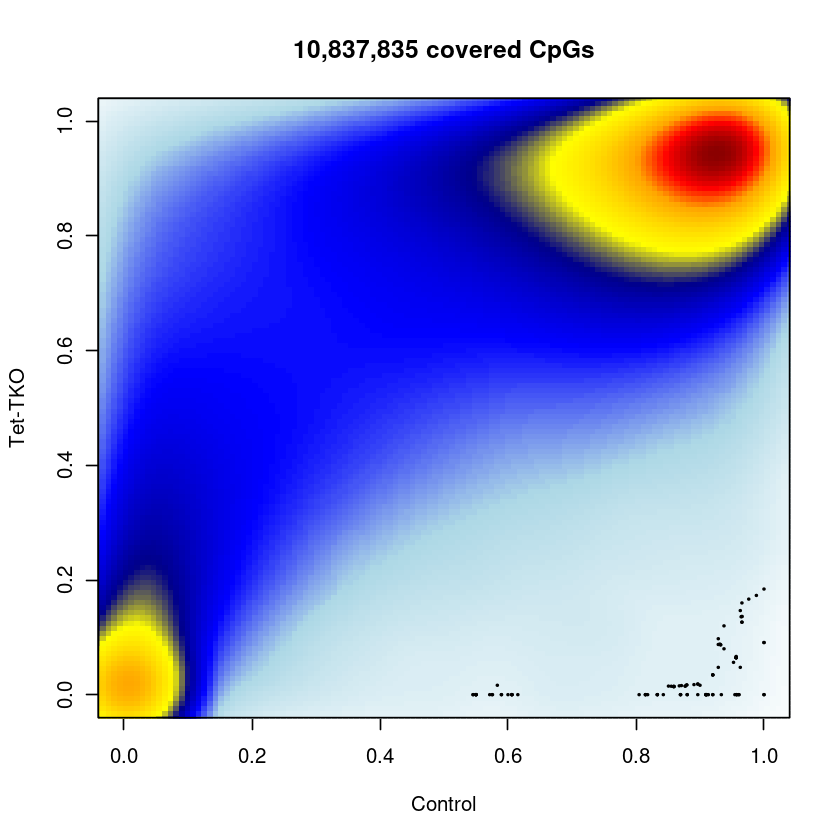

In [9]:
options(repr.plot.width = 7, repr.plot.height = 7)
min_cov <- 20
plot_smooth_cpg_scatter(meth_df_comp, "ctrl", "tet_tko", min_cov, "Control", "Tet-TKO")

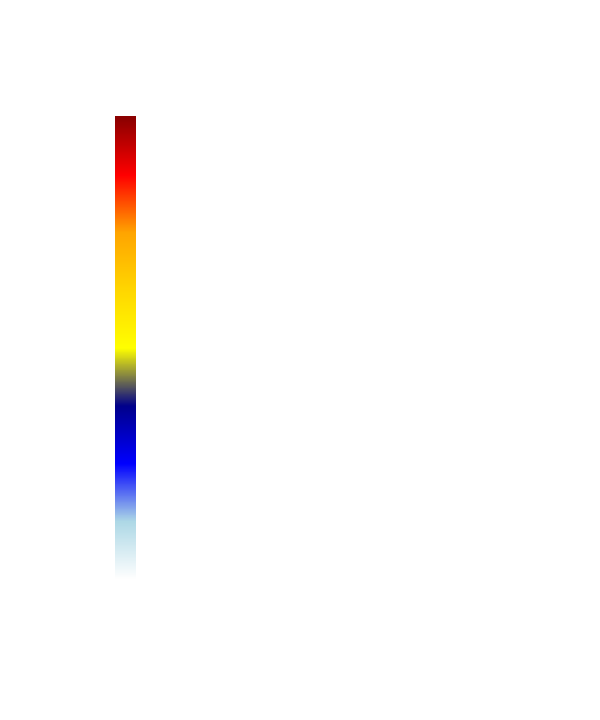

In [10]:
options(repr.plot.width = 5, repr.plot.height = 6)
plot_smooth_legend(c("white", "lightblue", "blue", "darkblue", "yellow", "gold", "orange", "red", "darkred"))

## Methylation in TADs

We took TAD defnitions from Nagano et al., 2017:

In [11]:
tad_intervs <- gintervals.load("scell.nextera.pool_good_hyb_es_b_TADs")  %>% as_tibble()
dim(tad_intervs)

[1] 2461    4

We can then extract average methylation in TADs and then remove from it ('punctuate') the methylation calls that are at k4me3 or k27me3 peaks, or that are at methylation dips or ATAC peaks:

In [12]:
tads_meth <- get_cpg_meth_tads(tad_intervs, meth_dips, k4me3_peaks, k27me3_peaks, atac_peaks) %cache_df% here("output/tads_meth.tsv") %>% as_tibble()

### Compare TAD methylation in Ctrl and TET-tko (Figure 5C)

ctrl_bins,n
<fct>,<int>
"(0.7,0.8]",38
"(0.8,0.83]",176
"(0.83,0.86]",864
"(0.86,0.89]",2746
"(0.89,1]",866


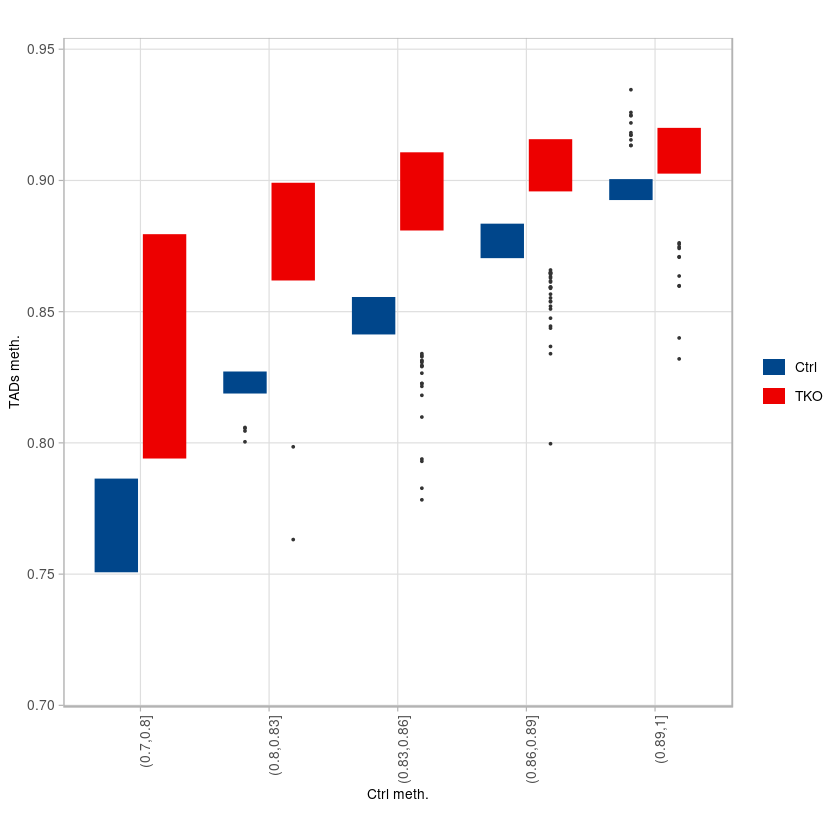

In [13]:
options(repr.plot.width = 7, repr.plot.height = 7)
df <- tads_meth %>% 
    filter(ctrl.cov >= 3e3, tet_tko.cov >= 3e3) %>% 
    mutate(l = end - start) %>% 
    filter(l >= 5e4) %>%
    mutate(ctrl_bins = cut(ctrl, c(0.7,0.8,0.83,0.86,0.89,1))) %>%
    select(chrom, start, end, ctrl_bins, Ctrl=ctrl, TKO=tet_tko) %>% 
    gather("type", "meth", -(chrom:ctrl_bins)) 

df %>% count(ctrl_bins)

p_tads_boxp <- df %>%    
    ggplot(aes(x=ctrl_bins, y=meth, fill=type)) + 
        geom_boxplot(lwd = 0.01, outlier.size = 0.001, fatten = 0.1) + 
        scale_fill_manual(name="", values = c("Ctrl" = "#00468BFF", "TKO" = "#ED0000FF")) + 
        theme(aspect.ratio=1) + 
        vertical_labs() + 
        xlab("Ctrl meth.") + 
        ylab("TADs meth.")
p_tads_boxp

In [14]:
df <- tads_meth %>% 
    filter(ctrl.cov >= 3e3, tet_tko.cov >= 3e3) %>% 
    mutate(l = end - start) %>% 
    filter(l >= 5e4) %>%
    summarise(
        tet_tko_mean = mean(tet_tko), 
        tet_tko_sd = sd(tet_tko, na.rm=TRUE), 
        ctrl_mean = mean(ctrl), 
        ctrl_sd = sd(ctrl, na.rm=TRUE), 
        e7.5_mean = mean(e7.5), 
        e7.5_sd = sd(e7.5, na.rm=TRUE),
        e8.5_mean = mean(e8.5), 
        e8.5_sd = sd(e8.5, na.rm=TRUE))
df
df %>%
    summarise_at(vars(everything()), function(x) round(x, digits=2))

ks.test(tads_meth$ctrl, tads_meth$tet_tko)    

tet_tko_mean,tet_tko_sd,ctrl_mean,ctrl_sd,e7.5_mean,e7.5_sd,e8.5_mean,e8.5_sd
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.9017096,0.02115242,0.8723345,0.02194502,0.7953908,0.03149332,0.8195952,0.02755257


tet_tko_mean,tet_tko_sd,ctrl_mean,ctrl_sd,e7.5_mean,e7.5_sd,e8.5_mean,e8.5_sd
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.9,0.02,0.87,0.02,0.8,0.03,0.82,0.03


Warning message in ks.test(tads_meth$ctrl, tads_meth$tet_tko):
"p-value will be approximate in the presence of ties"



	Two-sample Kolmogorov-Smirnov test

data:  tads_meth$ctrl and tads_meth$tet_tko
D = 0.62739, p-value < 2.2e-16
alternative hypothesis: two-sided


We can see that that the variation in background methylation between TADs was greatly diminished in Tet-TKO cells.

### Figure S6A

ctrl_bins,n
<fct>,<int>
"(0.7,0.8]",38
"(0.8,0.83]",176
"(0.83,0.86]",864
"(0.86,0.89]",2746
"(0.89,1]",866


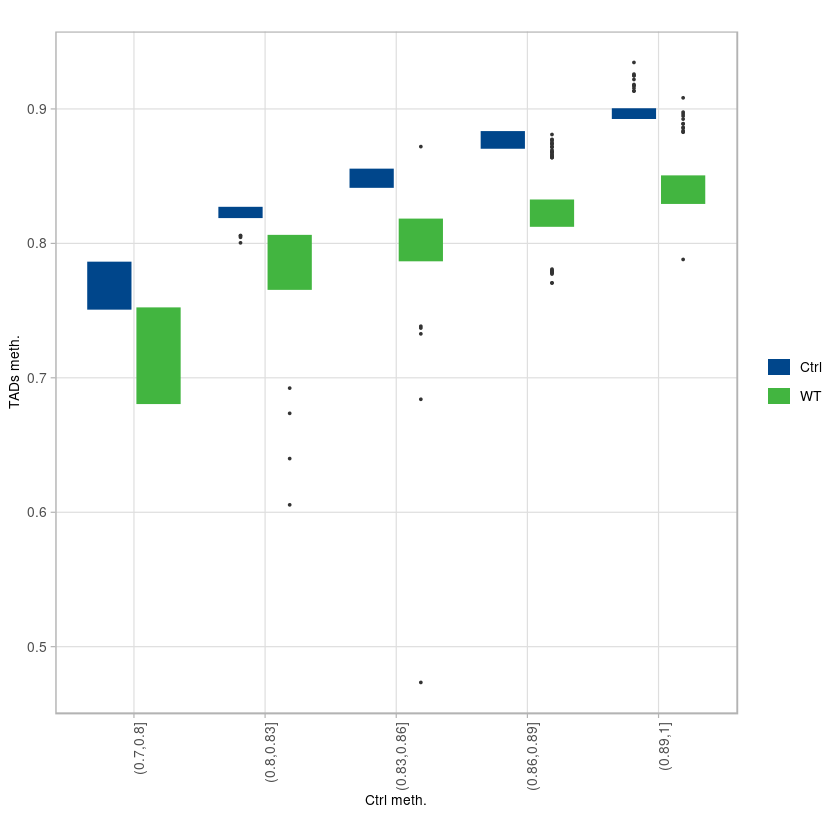

In [15]:
options(repr.plot.width = 7, repr.plot.height = 7)
df <- tads_meth %>% 
    filter(ctrl.cov >= 3e3, tet_tko.cov >= 3e3) %>% 
    mutate(l = end - start) %>% 
    filter(l >= 5e4) %>%
    mutate(ctrl_bins = cut(ctrl, c(0.7,0.8,0.83,0.86,0.89,1))) %>%
    select(chrom, start, end, ctrl_bins, Ctrl=ctrl, WT=e8.5) %>% 
    gather("type", "meth", -(chrom:ctrl_bins)) 

df %>% count(ctrl_bins)

p_tads_wt_boxp <- df %>%    
    ggplot(aes(x=ctrl_bins, y=meth, fill=type)) + 
        geom_boxplot(lwd = 0.01, outlier.size = 0.001, fatten = 0.1) + 
        scale_fill_manual(name="", values = c("Ctrl" = "#00468BFF", "WT" = "#42B540FF")) + 
        theme(aspect.ratio=1) + 
        vertical_labs() + 
        xlab("Ctrl meth.") + 
        ylab("TADs meth.")
p_tads_wt_boxp

We can see that our analysis infers higher methylation levels in the embryo compared to some previously published WT data. This is likely due to the elimination of extraembryonic ectoderm from the analysis, which represents a more hypomethylated (Smith et al., 2017) cell population that can affect the estimation of average methylation when not excluded.

## TAD methylation at different TOR regimes (Figure 5D)

`geom_smooth()` using formula 'y ~ x'



type,cor
<chr>,<dbl>
ctrl,-0.2692618
tet_tko,0.2265352


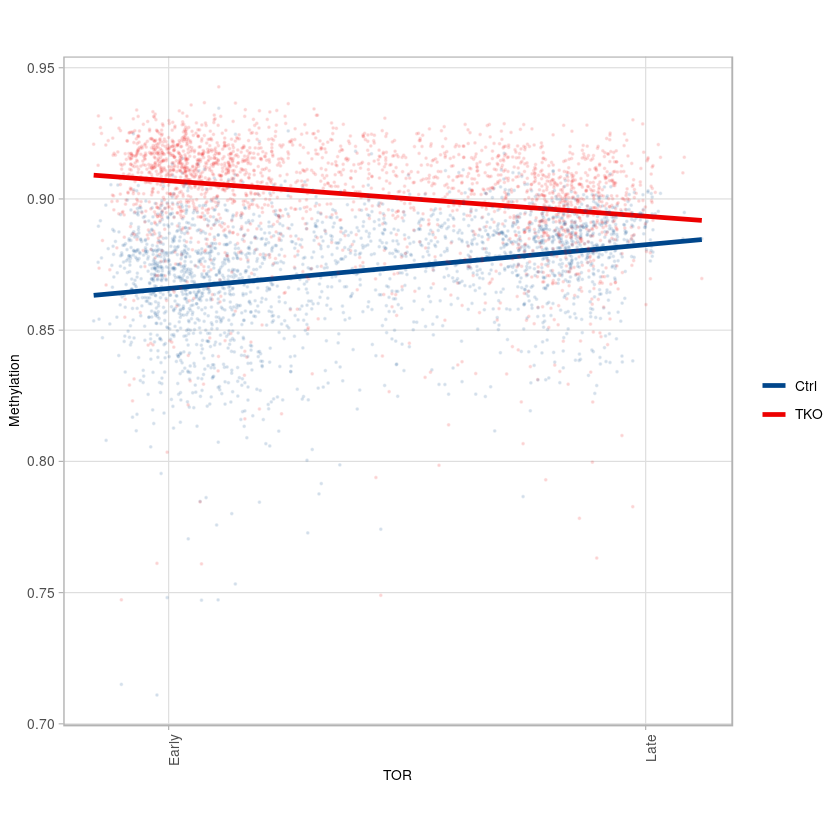

In [16]:
options(repr.plot.width = 7, repr.plot.height = 7)
p_tads_tor <- tads_meth %>% 
    filter(ctrl.cov >= 3e3, tet_tko.cov >= 3e3) %>% 
    mutate(l = end - start) %>% 
    filter(l >= 5e4) %>% 
    rename(Ctrl = ctrl, TKO = tet_tko) %>% 
    pivot_longer(Ctrl:TKO, names_to="type", values_to = "meth") %>% 
    ggplot(aes(x=-tor, y=meth, color=type)) + 
        geom_smooth(method=lm, se=FALSE) + 
        geom_point(size=0.01, alpha=0.1) + 
        theme(aspect.ratio=1) + 
        xlab("TOR") + 
        ylab("Methylation") + 
        scale_color_manual(name="", values = c("Ctrl" = "#00468BFF", "TKO" = "#ED0000FF")) + 
        scale_x_continuous(breaks=c(-1, 1), labels = c("Early", "Late")) + 
        vertical_labs()
p_tads_tor

tads_meth %>% 
    filter(ctrl.cov >= 3e3, tet_tko.cov >= 3e3) %>%  
    mutate(l = end - start) %>% filter(l >= 5e4) %>% 
    pivot_longer(ctrl:tet_tko, names_to="type", values_to = "meth") %>% group_by(type) %>% summarise(cor = cor(meth, tor))

We see that that lower background methylation is linked with early replicating TADs in control and a reciprocal effect in Tet-TKO.
These data support a role for widespread TET-mediated de-methylation in early replicating TADs, which is lost upon Tet knockout. Such de-methylation may rely on the enhanced accessibility of early replicating domains as part of the chromosomal A-compartment (López-Moyado et al., 2019; Pope et al., 2014).

## Low methylation hotspots

We extract chromatin marks at hotspots of low methylation (control methylation <0.25):

In [17]:
define_chip_vtracks()

low_meth_df <- meth_df_comp %>%     
    select(chrom, start, end, ctrl, tet_tko, e8.5, ctrl.cov, tet_tko.cov, e8.5.cov) %>% 
    gextract.left_join(
    c("pmax(-log2(1-ecto_k27me3),-log2(1-endo_k27me3),-log2(1-meso_k27me3),-log2(1-ps_k27me3),-log2(1-e6_epi_k27me3),-log2(1-e5_epi_k27me3),-log2(1-e6_ve_k27me3),-log2(1-e10_fc_k27me3),-log2(1-e10_forebrain_k27me3),-log2(1-e10_heart_k27me3),-log2(1-e10_hindbrain_k27me3),-log2(1-e10_limb_k27me3),-log2(1-e10_midbrain_k27me3),-log2(1-es_k27me3), na.rm=TRUE)",
      "pmax(-log2(1-e10_limb_k4me3),-log2(1-e10_heart_k4me3),-log2(1-e10_midbrain_k4me3),-log2(1-e10_hindbrain_k4me3),-log2(1-e10_forebrain_k4me3),-log2(1-e11_liver_k4me3),-log2(1-ecto_k4me3),-log2(1-endo_k4me3),-log2(1-meso_k4me3),-log2(1-ps_k4me3),-log2(1-e6_epi_k4me3),-log2(1-e5_epi_k4me3),-log2(1-e6_ve_k4me3), na.rm=TRUE)"),
    iterator=., intervals=., colnames=c("k27me3", "k4me3")) %>% 
    select(-(chrom1:end1)) %cache_df% 
    here("output/meth_marks_smoothed.tsv") %>% 
    as_tibble()

### Figure S6B

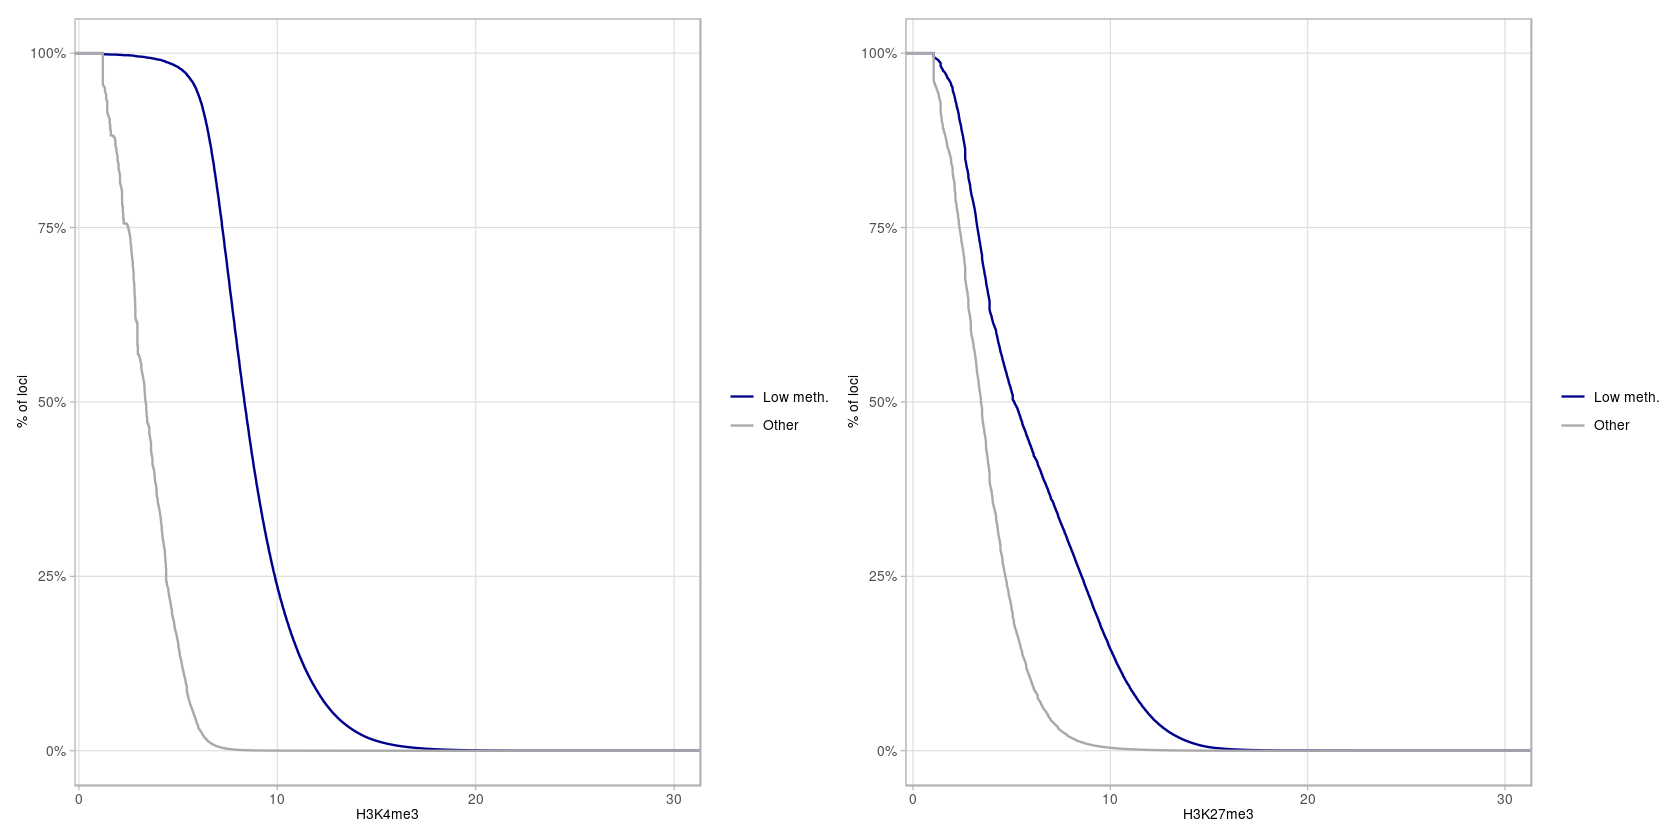

In [18]:
options(repr.plot.width = 14, repr.plot.height=7)
df <- low_meth_df %>%
        filter(ctrl.cov >= 10) %>%
        mutate(low_meth = ifelse(ctrl <= 0.25, "Low meth.", "Other")) 

p_k4me3 <- df %>% 
        ggplot(aes(x=k4me3, color=low_meth, y = 1-..y..)) +
            stat_ecdf() +
            scale_color_manual("", values = c("darkblue", "darkgray")) +
            scale_y_continuous(labels=scales::percent) +
            ylab("% of loci") +
            xlab("H3K4me3")

p_k27me3 <- df %>% 
        ggplot(aes(x=k27me3, color=low_meth, y = 1-..y..)) +
            stat_ecdf() +
            scale_color_manual("", values = c("darkblue", "darkgray")) +
            scale_y_continuous(labels=scales::percent) +
            ylab("% of loci") +
            xlab("H3K27me3")

p_k4me3 + p_k27me3

## K4me3/K27me3 hospots (Figure 5E)

### K4me3 hotspots

In [19]:
d_k4me3 <- extract_meth_at_context(k4me3_peaks) %cache_df% here("output/k4me3_meth_comp.tsv") %>% as_tibble()

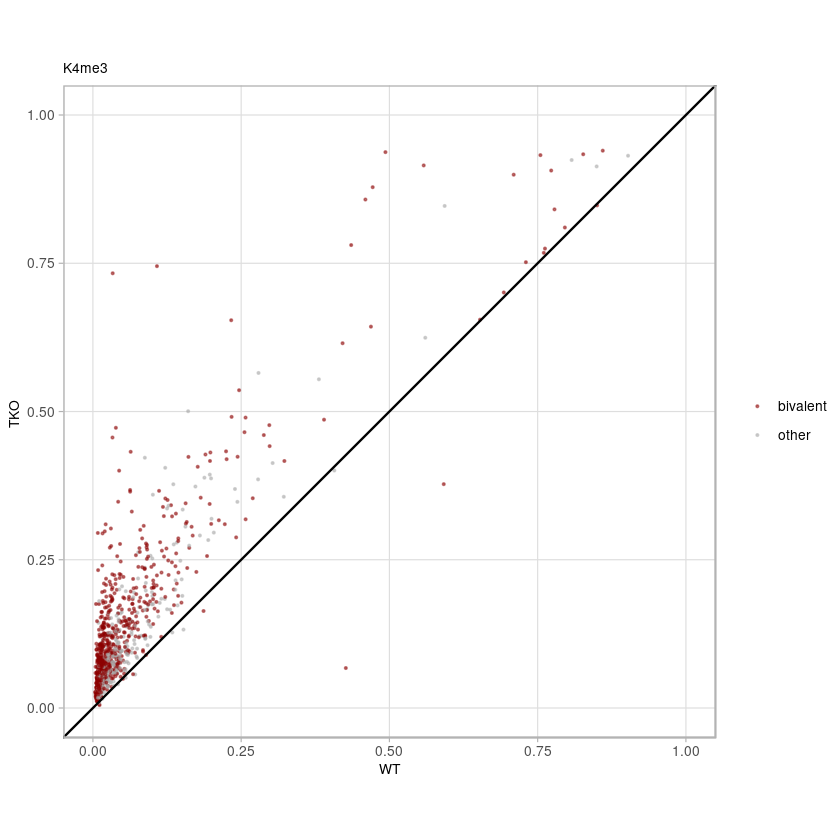

In [20]:
options(repr.plot.width = 7, repr.plot.height = 7)
df_k4me3 <- d_k4me3 %>% 
    filter(ctrl.cov >= 50, tet_tko.cov >= 50) %>% 
    gintervals.neighbors1(k27me3_peaks) %>% 
    mutate(type = ifelse(dist == 0, "bivalent", "other")) %>% 
    select(-(chrom1:dist)) %>% 
    mutate(l = end - start) %>% 
    filter(abs(l) >= 3e3) 

p_k4me3 <- df_k4me3 %>% 
    ggplot(aes(x=ctrl, y=tet_tko, color=type)) + 
        geom_point(size=0.1, alpha=0.5) + 
        theme(aspect.ratio=1) + 
        geom_abline() + 
        theme(aspect.ratio=1) + 
        scale_color_manual(name="", values=c("bivalent" = "darkred", "other" = "darkgray")) +  
        ggtitle("K4me3") + 
        xlab("WT") + 
        ylab("TKO ") + 
        xlim(0,1) + 
        ylim(0,1)

p_k4me3

In [21]:
df_k4me3 %>% count(type)
nrow(df_k4me3)

type,n
<chr>,<int>
bivalent,668
other,285


[1] 953

In [22]:
df_k4me3 %>% 
    select(chrom:end, ctrl, tet_tko, type) %>% 
    mutate(diff = tet_tko - ctrl) %>% 
    filter(diff >= 0) %>% 
    summarise(min_diff = min(diff), max_diff = max(diff), m = mean(diff), sd = sd(diff)) %>% 
    summarise_at(vars(everything()), scales::percent)

min_diff,max_diff,m,sd
<chr>,<chr>,<chr>,<chr>
0%,70%,8%,7%


### K27me3 hotspots

In [23]:
d_k27me3 <- extract_meth_at_context(k27me3_peaks) %cache_df% here("output/k27me3_meth_comp.tsv") %>% as_tibble()

Polycomb without methylation of k4me3 regions ("punctuated"):

In [24]:
d_k27me3_punc <-  gextract_meth(c(comb_tracks, "e8_5", "Zhang_Nature_Genetics_2017.Ect_mCG", "Zhang_Nature_Genetics_2017.End_mCG", "Zhang_Nature_Genetics_2017.Mes_mCG", "Zhang_Nature_Genetics_2017.E65Epi_mCG"), names=c(comb_names, "e8.5", "ecto", "endo", "meso", "epi"), extract_meth_calls=TRUE, intervals=k27me3_peaks, join_intervals = TRUE) %>% 
    mutate(e7.5.meth = ecto.meth + endo.meth + meso.meth, e7.5.cov = ecto.cov + endo.cov + meso.cov, e7.5 = e7.5.meth / e7.5.cov)  %>% 
    gintervals.neighbors1(k4me3_peaks) %>% 
    filter(dist != 0) %>% 
    group_by(chrom1, start1, end1) %>% 
    summarise_at(vars(ends_with("cov"), ends_with("meth")), sum, na.rm=TRUE) %>% 
    rename(chrom=chrom1, start=start1, end=end1) %>% 
    mutate(ctrl = ctrl.meth / ctrl.cov, tet_tko = tet_tko.meth / tet_tko.cov, e8.5 = e8.5.meth / e8.5.cov, e7.5 = e7.5.meth / e7.5.cov, epi = epi.meth / epi.cov) %>% 
    ungroup() %cache_df% here("output/k27me3_meth_comp_k4me3_punc.tsv") %>% as_tibble()

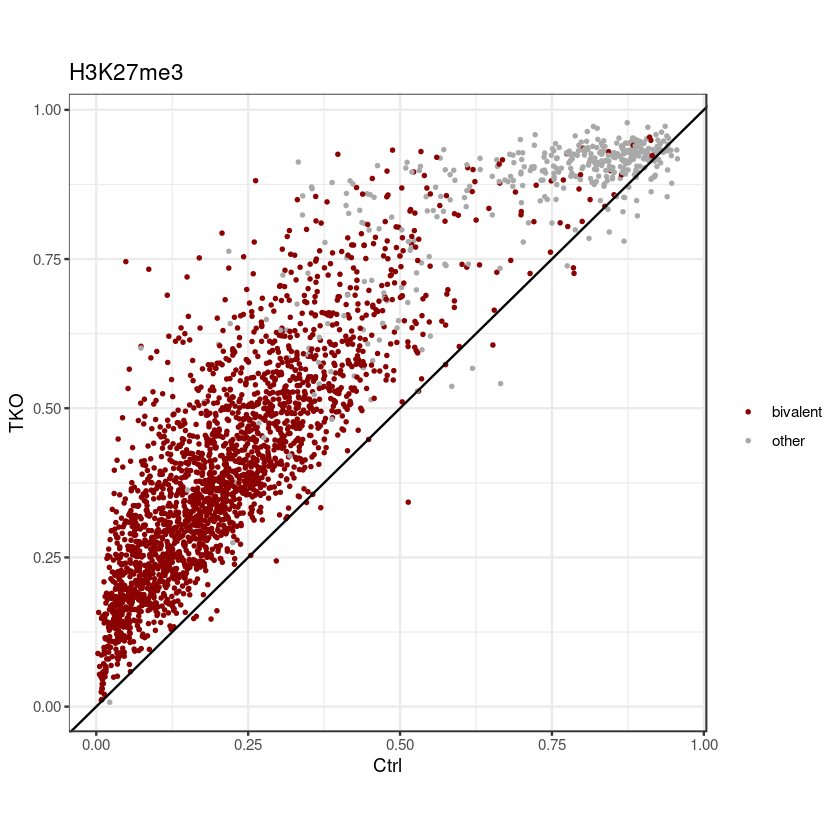

In [25]:
options(repr.plot.width = 7, repr.plot.height = 7)
df <- d_k27me3 %>% 
    filter(ctrl.cov >= 50, tet_tko.cov >= 50) %>% 
    gintervals.neighbors1(k4me3_peaks) %>% 
    mutate(type = ifelse(dist == 0, "bivalent", "other")) %>% 
    select(-(chrom1:dist)) %>% 
    mutate(l = end - start) %>% 
    filter(abs(l) >= 3e3)  
p_k27me3 <- df %>% 
    ggplot(aes(x=ctrl, y=tet_tko, color=type)) + 
        geom_point(size=0.5) + 
        theme(aspect.ratio=1) + 
        geom_abline() + 
        theme_bw() + 
        theme(aspect.ratio=1) + 
        scale_color_manual(name = "", values=c("bivalent" = "darkred", "other" = "darkgray")) +  
        ggtitle("H3K27me3")  + 
        xlab("Ctrl") + 
        ylab("TKO")

p_k27me3

In [26]:
df %>% count(type)
nrow(df)

type,n
<chr>,<int>
bivalent,2298
other,402


[1] 2700

H3k27me3 hotspots while removing H3K4me3 methylation:

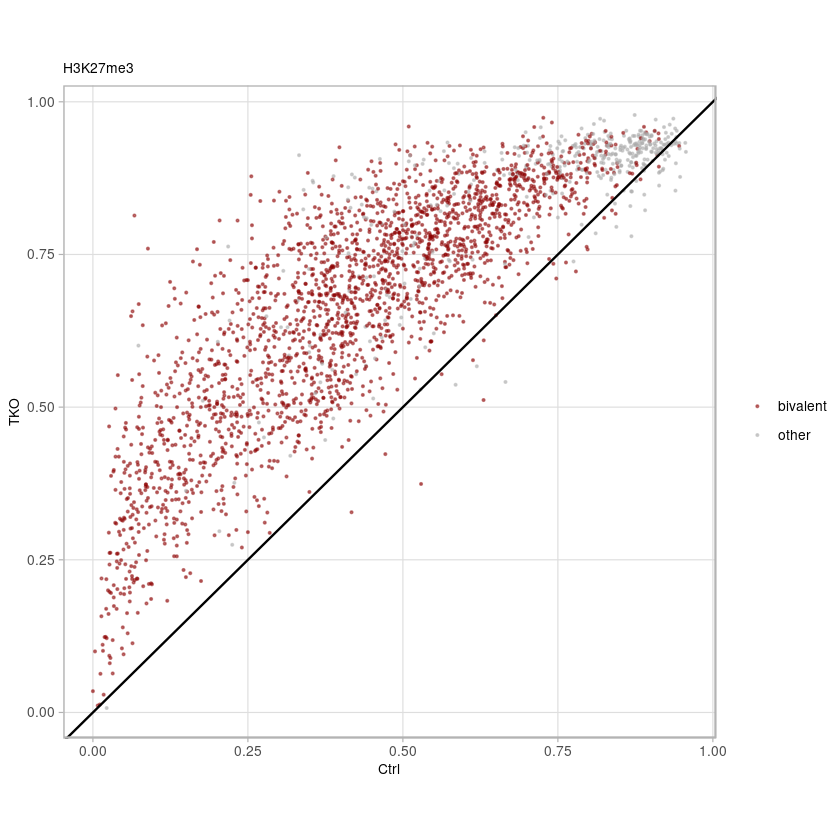

In [27]:
options(repr.plot.width = 7, repr.plot.height = 7)
df_punc <- d_k27me3_punc %>% 
    filter(ctrl.cov >= 50, tet_tko.cov >= 50) %>% 
    gintervals.neighbors1(k4me3_peaks) %>% 
    mutate(type = ifelse(dist == 0, "bivalent", "other")) %>% 
    select(-(chrom1:dist)) %>% 
    mutate(l = end - start) %>% 
    filter(abs(l) >= 3e3)

p_k27_punc <- df_punc %>% 
    ggplot(aes(x=ctrl, y=tet_tko, color=type)) + 
        geom_point(size=0.1, alpha=0.5) + 
        theme(aspect.ratio=1) + 
        geom_abline() + 
        theme(aspect.ratio=1) + 
        scale_color_manual(name="", values=c("bivalent" = "darkred", "other" = "darkgray")) + 
        ggtitle("H3K27me3") + xlab("Ctrl") + ylab("TKO") 
p_k27_punc

In [28]:
df_punc %>% 
    select(chrom:end, ctrl, tet_tko) %>% 
    mutate(diff = tet_tko - ctrl) %>% 
    filter(diff >= 0) %>% 
    summarise(min_diff = min(diff), max_diff = max(diff), m = mean(diff), sd = sd(diff)) %>% 
    summarise_at(vars(everything()), scales::percent)

min_diff,max_diff,m,sd
<chr>,<chr>,<chr>,<chr>
0%,75%,23%,12%


In [29]:
bind_rows(df_k4me3, df_punc) %>% 
    select(chrom:end, ctrl, tet_tko, type) %>% 
    mutate(diff = tet_tko - ctrl) %>% 
    filter(diff >= 0) %>% 
    summarise(min_diff = min(diff), max_diff = max(diff), m = mean(diff), sd = sd(diff)) %>% 
    summarise_at(vars(everything()), scales::percent)

min_diff,max_diff,m,sd
<chr>,<chr>,<chr>,<chr>
0%,75%,19%,13%


In [30]:
n_above <- bind_rows(df_k4me3, df_punc) %>% 
    select(chrom:end, ctrl, tet_tko, type) %>%     
    filter(ctrl <= 0.25, tet_tko >= 0.5) %>% 
    nrow()

scales::percent(n_above / nrow(bind_rows(df_k4me3, df_punc) ))


[1] "5%"

In [31]:
df_punc %>% count(type)
nrow(df_punc)

type,n
<chr>,<int>
bivalent,2185
other,402


[1] 2587

## Loci linked with CTCF occupancy (Figure 5F)

In [32]:
tet_df <- meth_df_comp %>% filter(ctcf >= 0.999)
tet_df <- tet_df %>% gintervals.neighbors1(k4me3_peaks) %>% mutate(type = ifelse(dist == 0, "k4me3", "other")) %>% select(chrom:end, ctrl.cov, tet_tko.cov, ctrl, tet_tko, ctcf, type)

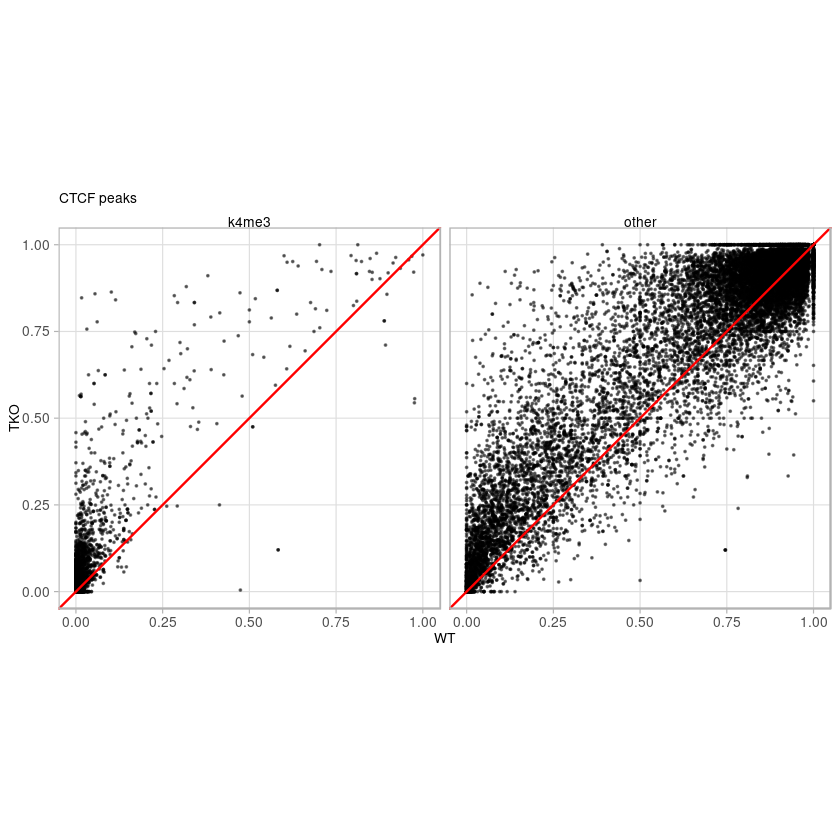

In [33]:
options(repr.plot.width=7, repr.plot.height=7)
min_cov <- 20
p_ctcf <- tet_df %>% 
    filter(ctrl.cov >= min_cov, tet_tko.cov >= min_cov) %>% 
    ggplot(aes(x=ctrl, y=tet_tko)) + 
    geom_point(size=0.001, alpha=0.5) + 
    theme(aspect.ratio=1) + 
    geom_abline(color = "red") + 
    facet_wrap(~type) + 
    ggtitle("CTCF peaks") + 
    xlab("WT") + 
    ylab("TKO")

p_ctcf

In [34]:
tet_df %>% 
    filter(ctrl.cov >= min_cov, tet_tko.cov >= min_cov) %>% 
    count(type)

type,n
<chr>,<int>
k4me3,3276
other,17860


## Methylation at Exons and Non-H3K4me3 Promoters (Figure 5G)

### Exons

In [35]:
d_exons <- extract_meth_at_context("intervs.global.exons") %cache_df% here("output/exons_meth_comp.tsv") %>% as_tibble()
d_exons <- d_exons %>% gintervals.neighbors1(k4me3_peaks) %>% filter(abs(dist) > 0) %>% select(-(chrom1:dist))  %>% gintervals.neighbors1(k27me3_peaks) %>% filter(abs(dist) > 0) %>% select(-(chrom1:dist))

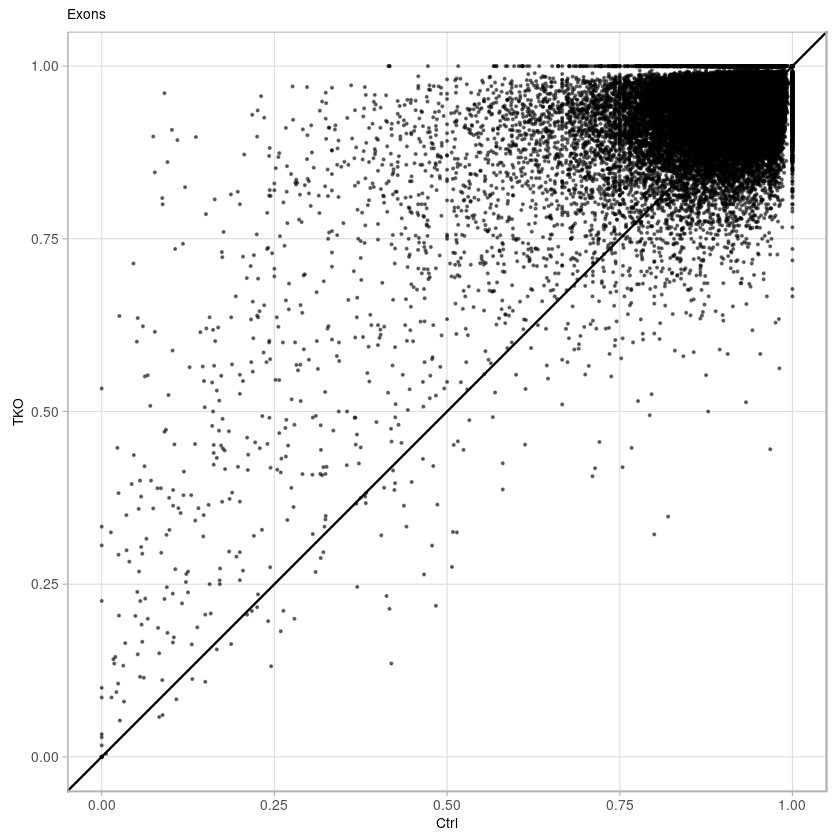

In [36]:
options(repr.plot.width = 7, repr.plot.height = 7)
p_exons <- d_exons %>% 
    filter(ctrl.cov >= 30, tet_tko.cov >= 30) %>% 
    ggplot(aes(x=ctrl, y=tet_tko)) + 
    geom_point(size=0.1, alpha=0.5) + 
    theme(aspect.ratio=1) + 
    geom_abline() + 
    theme(aspect.ratio=1) + 
    ggtitle("Exons") + 
    xlab("Ctrl") + 
    ylab("TKO")
p_exons

In [37]:
d_exons %>% 
    filter(ctrl.cov >= 30, tet_tko.cov >= 30)  %>% 
    nrow()

[1] 47734

### Compare with the WT (Figure S6C):

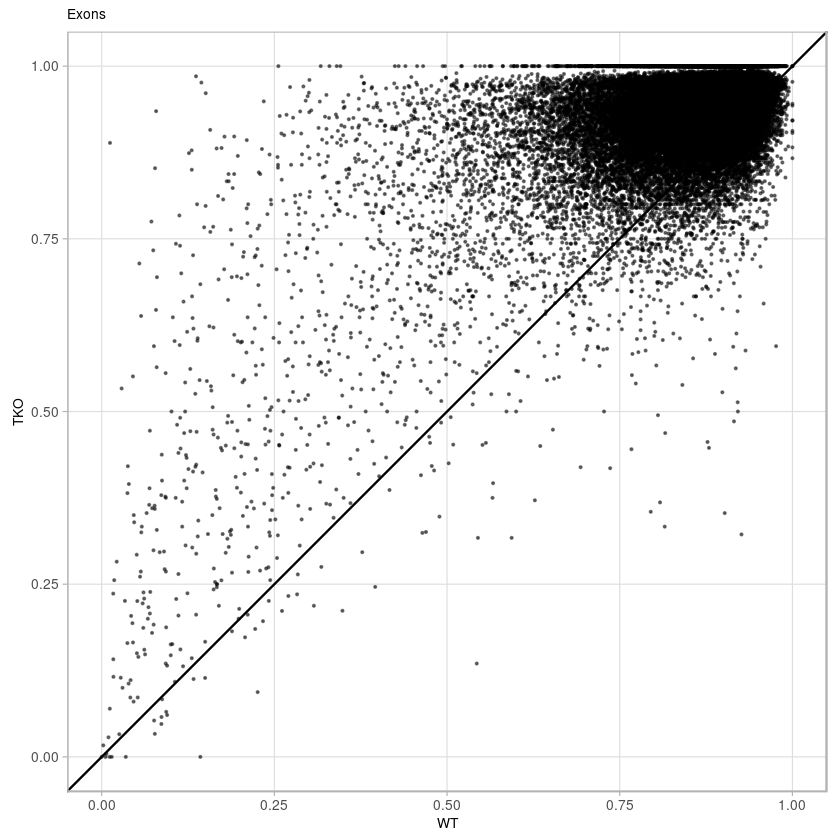

In [38]:
options(repr.plot.width = 7, repr.plot.height = 7)
p_exons_vs_wt <- d_exons %>% 
    filter(e7.5.cov >= 30, tet_tko.cov >= 30) %>% 
    ggplot(aes(x=e7.5, y=tet_tko)) + 
    geom_point(size=0.1, alpha=0.5) + 
    theme(aspect.ratio=1) + 
    geom_abline() + 
    theme(aspect.ratio=1) + 
    ggtitle("Exons") + 
    xlab("WT") + 
    ylab("TKO")
p_exons_vs_wt

### Promoters

In [39]:
d_promoters <-  extract_meth_at_context(get_promoters()) %cache_df% here("output/promoter_meth_comp.tsv") %>% as_tibble()

Annotate promoters to 'k4me3', 'k27me3', 'bivalent' and other ('none'):

In [40]:
d_promoters <- d_promoters %>% 
    gintervals.neighbors1(k4me3_peaks) %>% 
    mutate(k4me3 = dist == 0) %>% 
    select(-(chrom1:dist)) %>% 
    gintervals.neighbors1(k27me3_peaks) %>% 
    mutate(k27me3 = dist == 0) %>% 
    select(-(chrom1:dist)) %>% 
    mutate(type = case_when(k27me3 & k4me3 ~ "bivalent", k4me3 ~ "k4me3", k27me3 ~ "k27me3", TRUE ~ "none"))

Add time of replication annotation:

In [41]:
d_promoters <- gextract.left_join("tor", intervals=d_promoters, iterator=d_promoters) %>% as_tibble() %>% select(-(chrom1:end1))

We match the promoters with marginal expression data from the gastrulation atlas (Mittnenzweig, Meishar et. al. Cell 2021):

In [42]:
atlas_egc <- readr::read_rds(here("data/atlas_egc.rds"))
atlas_marginal <- tibble(gene = rownames(atlas_egc), expr=log2(rowSums(atlas_egc) + 1e-5))

#### Non-H3Kme3 promoters

We require a coverage of at least 30: 

In [43]:
df <- d_promoters %>% 
    filter(type == "none", ctrl.cov >= 30, tet_tko.cov >= 30) %>% 
    left_join(get_promoters() %>% select(chrom:end, gene=geneSymbol)) %>% 
    left_join(atlas_marginal %>% separate_rows(gene, sep=";")) %>%     
    gintervals.neighbors1(cgi_intervs) %>% 
    mutate(cgi = ifelse(dist == 0, "cgi", "other")) %>% 
    filter(!is.na(expr)) 

Joining, by = c("chrom", "start", "end")
Joining, by = "gene"


In [44]:
df %>% filter(!is.na(ctrl), !is.na(tet_tko)) %>% nrow()

[1] 3381

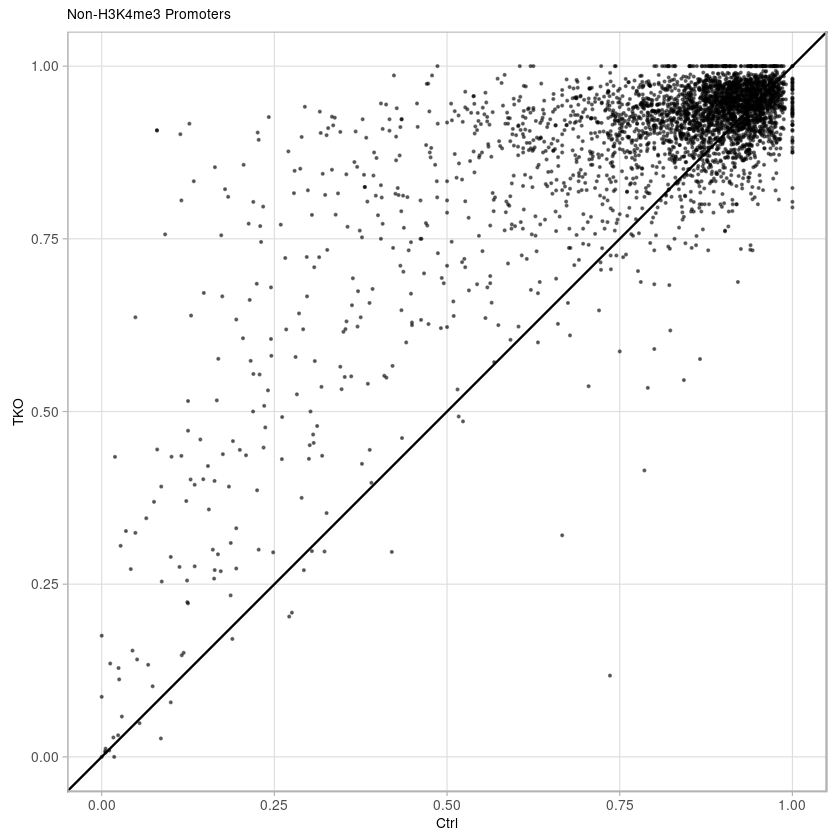

In [45]:
options(repr.plot.width = 7, repr.plot.height = 7)
p_prom_none <- df %>%         
    ggplot(aes(x=ctrl, y=tet_tko)) + 
    geom_point(size=0.1, alpha=0.5) + 
    theme(aspect.ratio=1) + 
    geom_abline() + 
    theme(aspect.ratio=1) + 
    ggtitle("Non-H3K4me3 Promoters") + 
    xlab("Ctrl") + 
    ylab("TKO")
p_prom_none

### Compare with the WT (Figure S6C):

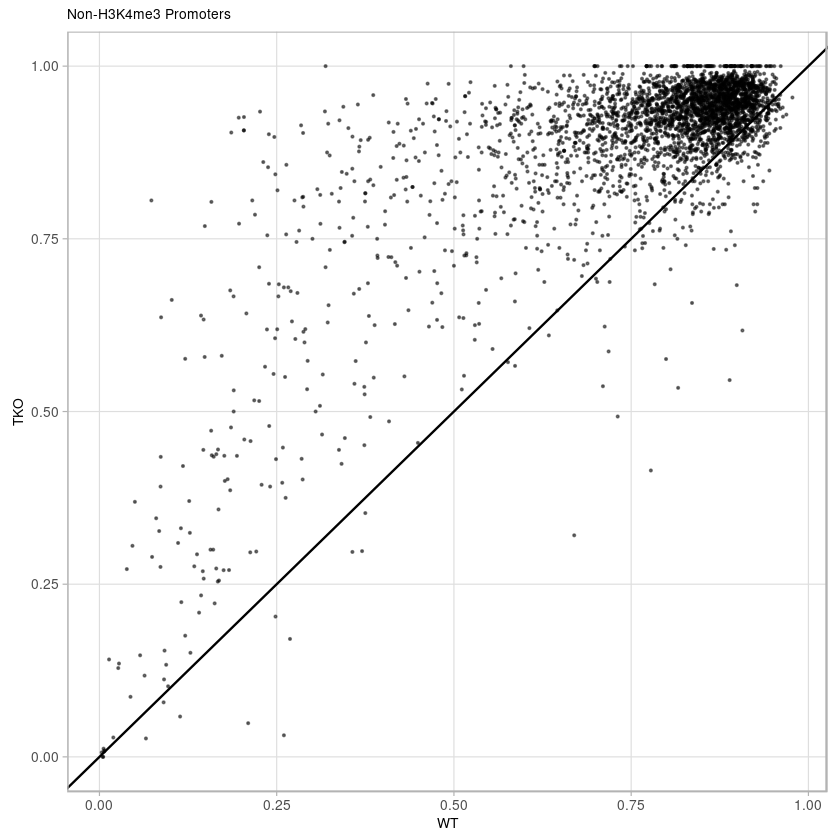

In [46]:
options(repr.plot.width = 7, repr.plot.height = 7)
p_prom_none_vs_wt <- df %>% 
    filter(e7.5.cov >= 30, tet_tko.cov >= 30) %>% 
    ggplot(aes(x=e7.5, y=tet_tko)) + 
    geom_point(size=0.1, alpha=0.5) + 
    theme(aspect.ratio=1) + 
    geom_abline() + 
    theme(aspect.ratio=1) + 
    ggtitle("Non-H3K4me3 Promoters") + 
    xlab("WT") + 
    ylab("TKO")
p_prom_none_vs_wt

## Promoter methylation vs expression (Figure S6D/S6E)

Load expression data of all the types and of epiblast:

In [47]:
egc_bulk <- fread(here("data/eg_bulk.tsv")) %>% as_tibble()
egc_epiblast <- fread(here("data/eg_epiblast.tsv")) %>% as_tibble()

We generate a table for all the covered promoters in wt.

In [48]:
promoters_table <- d_promoters %>% left_join(get_promoters() %>% select(chrom:end, strand, geneSymbol), by = c("chrom", "start", "end"))  %>%
    filter(ctrl.cov >= 30) %>%
    separate_rows(geneSymbol, sep=";") %>%
     # when there are alternative promoters - keep the one with lower methylation
    arrange(geneSymbol, ctrl) %>%
    distinct(geneSymbol, .keep_all = TRUE) %>%
     # add expression data
    left_join(egc_bulk %>% separate_rows(gene, sep=";") %>% rename(geneSymbol = gene),  by = "geneSymbol") %>%
    mutate_at(vars(ends_with("bulk")), function(x) log2(x + 1e-5)) %cache_df%
    here("output/promoter_table.tsv") %>% 
    as_tibble()

In [49]:
promoters_table %>%
        filter(wt_bulk >= -14) %>%
        count(type) %>%
        mutate(p = n / sum(n), perc = scales::percent(p))

type,n,p,perc
<chr>,<int>,<dbl>,<chr>
bivalent,542,0.107539683,10.8%
k27me3,21,0.004166667,0.4%
k4me3,4277,0.848611111,84.9%
none,200,0.039682540,4.0%


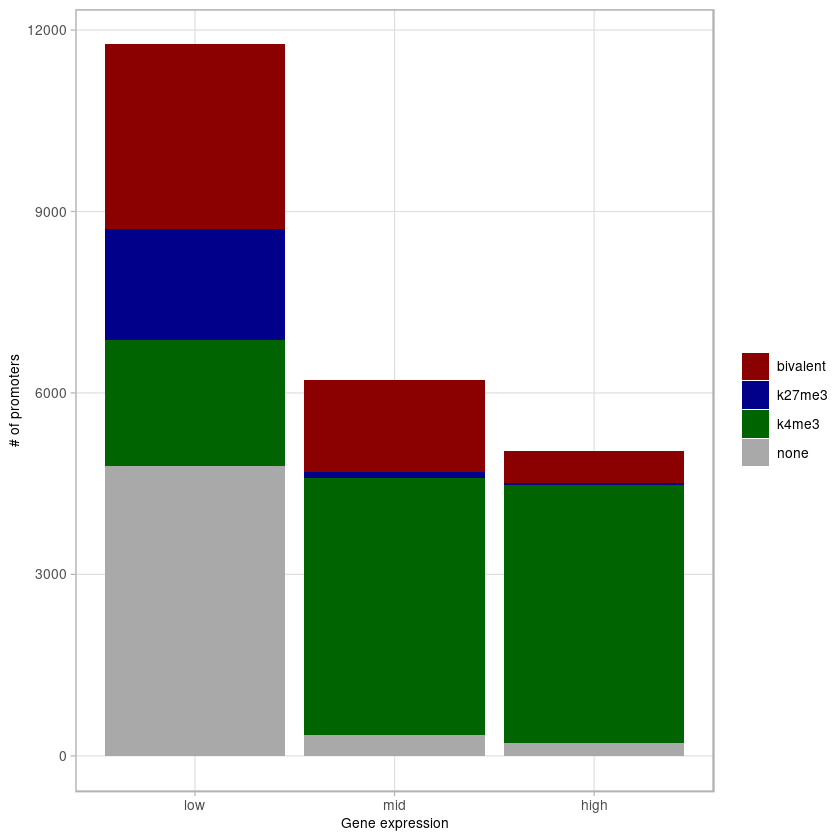

In [50]:
p_expr_marks <- promoters_table %>% 
    mutate(expr = cut(wt_bulk, c(-17, -16, -14, 0), labels=c("low", "mid", "high"))) %>% 
    filter(!is.na(expr)) %>% 
    count(expr, type) %>% 
    ggplot(aes(x=expr, y=n, fill=type)) + 
        geom_col() + 
        scale_fill_manual(name = "", values=c("bivalent" = "darkred", "k27me3" = "darkblue", "k4me3" = "darkgreen", "none" = "darkgray")) + 
        ylab("# of promoters") + 
        xlab("Gene expression")

p_expr_marks

In [51]:
define_chip_vtracks()
intervs <- promoters_table %>% select(chrom:end, geneSymbol, wt_bulk)
marks_expr <- gextract.left_join(
    c("pmax(-log2(1-ecto_k27me3),-log2(1-endo_k27me3),-log2(1-meso_k27me3),-log2(1-ps_k27me3),-log2(1-e6_epi_k27me3),-log2(1-e5_epi_k27me3),-log2(1-e6_ve_k27me3),-log2(1-e10_fc_k27me3),-log2(1-e10_forebrain_k27me3),-log2(1-e10_heart_k27me3),-log2(1-e10_hindbrain_k27me3),-log2(1-e10_limb_k27me3),-log2(1-e10_midbrain_k27me3),-log2(1-es_k27me3), na.rm=TRUE)",
      "pmax(-log2(1-e10_limb_k4me3),-log2(1-e10_heart_k4me3),-log2(1-e10_midbrain_k4me3),-log2(1-e10_hindbrain_k4me3),-log2(1-e10_forebrain_k4me3),-log2(1-e11_liver_k4me3),-log2(1-ecto_k4me3),-log2(1-endo_k4me3),-log2(1-meso_k4me3),-log2(1-ps_k4me3),-log2(1-e6_epi_k4me3),-log2(1-e5_epi_k4me3),-log2(1-e6_ve_k4me3), na.rm=TRUE)"),
    iterator=intervs, intervals=intervs, colnames=c("k27me3", "k4me3")) %>% select(-(chrom1:end1)) %cache_df% here("output/marks_expr.tsv") %>% as_tibble()

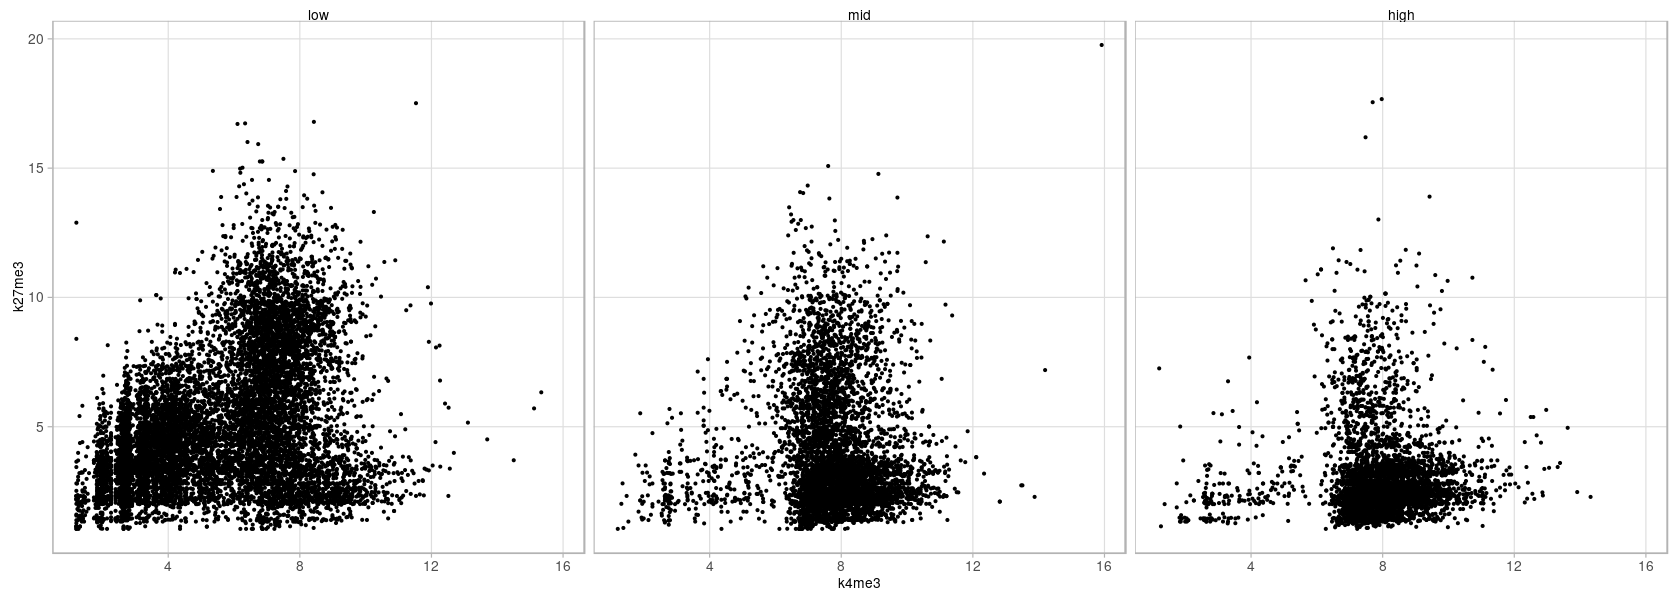

In [52]:
options(repr.plot.width=14, repr.plot.height=5)
marks_expr %>% 
    mutate(expr = cut(wt_bulk, c(-17, -16, -14, 0), labels=c("low", "mid", "high"))) %>% 
    filter(!is.na(expr)) %>% 
    ggplot(aes(x=k4me3, y=k27me3)) + 
        geom_point(size=0.1) + 
        facet_wrap(~expr) + 
        theme(aspect.ratio=1)

In [53]:
marks_expr %>% 
    mutate(expr = cut(wt_bulk, c(-17, -16, -14, 0), labels=c("low", "mid", "high"))) %>% filter(!is.na(k4me3)) %>% 
    count(expr)

expr,n
<fct>,<int>
low,11758
mid,6214
high,5040
NA,6


### Figure S6D

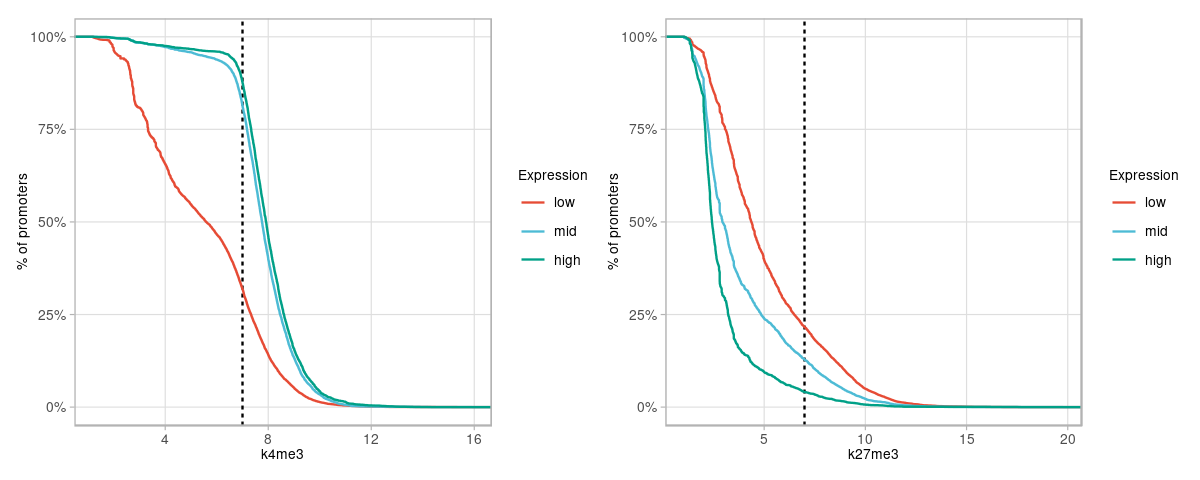

In [54]:
options(repr.plot.width=10, repr.plot.height=4)
p_k4me3 <- marks_expr %>% 
    mutate(expr = cut(wt_bulk, c(-17, -16, -14, 0), labels=c("low", "mid", "high"))) %>% 
    filter(!is.na(expr)) %>% 
    ggplot(aes(x=k4me3, color=expr, y=1-..y..)) +  
        geom_vline(xintercept = 7, linetype="dashed") + 
        stat_ecdf() + 
        ggsci::scale_color_npg(name = "Expression") + 
        ylab("% of promoters") + 
        scale_y_continuous(label=scales::percent)
p_k27me3 <- marks_expr %>% 
    mutate(expr = cut(wt_bulk, c(-17, -16, -14, 0), labels=c("low", "mid", "high"))) %>% 
    filter(!is.na(expr)) %>% 
    ggplot(aes(x=k27me3, color=expr, y=1-..y..)) + 
        geom_vline(xintercept = 7, linetype="dashed") + 
        stat_ecdf() + 
        ggsci::scale_color_npg(name = "Expression") + 
        ylab("% of promoters") + 
        scale_y_continuous(label=scales::percent)         

p_k4me3 + p_k27me3

In [55]:
promoters_table %>% 
    filter(type == "none") %>% 
    mutate(expr = cut(wt_bulk, c(-17, -16, -14, 0), labels=c("Low Expr.", "Mid Expr.", "High Expr."))) %>% 
    filter(!is.na(expr)) %>% 
    filter(ctrl.cov >= 30, tet_tko.cov >= 30) %>% 
    count(expr)

expr,n
<fct>,<int>
Low Expr.,3428
Mid Expr.,254
High Expr.,158


### Figure S6E

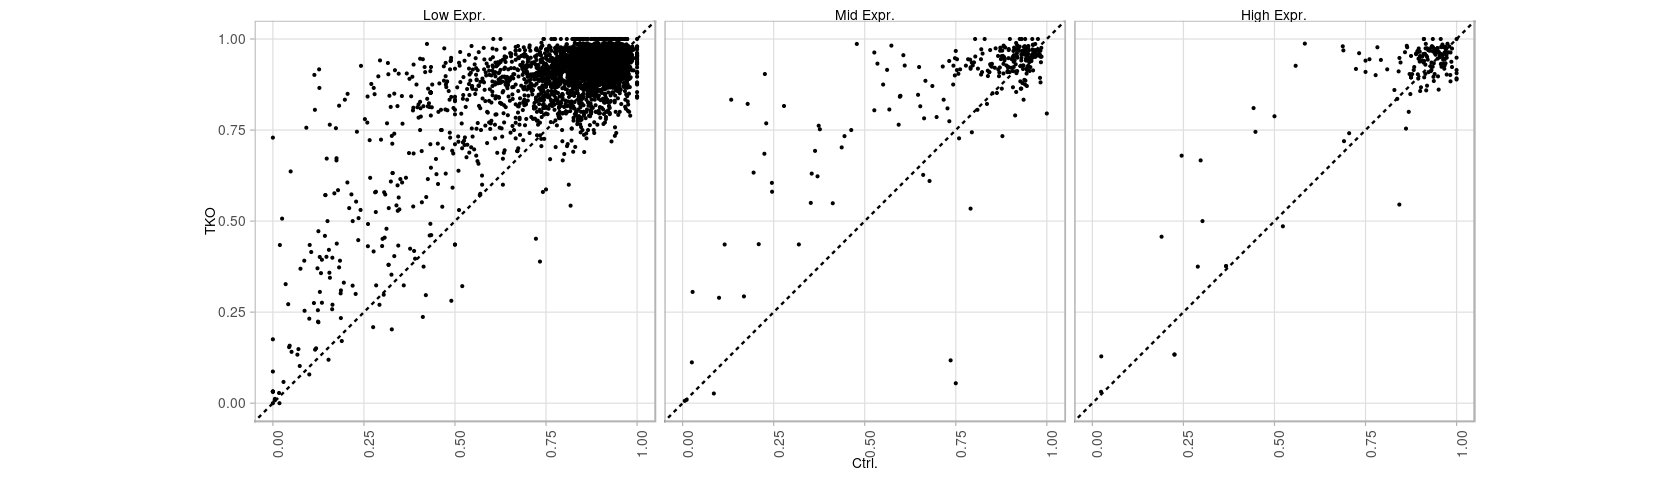

In [56]:
options(repr.plot.width=14, repr.plot.height=4)
p_wt_tko_expr <- promoters_table %>% 
    filter(type == "none") %>% 
    mutate(expr = cut(wt_bulk, c(-17, -16, -14, 0), labels=c("Low Expr.", "Mid Expr.", "High Expr."))) %>% 
    filter(!is.na(expr)) %>% 
    filter(ctrl.cov >= 30, tet_tko.cov >= 30) %>% 
    ggplot(aes(x=ctrl, y=tet_tko)) + 
        geom_abline(linetype="dashed") + 
        geom_point(size=0.1) + 
        facet_wrap(~expr) + 
        theme(aspect.ratio=1) + 
        vertical_labs() + 
        xlab("Ctrl.") + 
        ylab("TKO")

p_wt_tko_expr

## Putative enhancers

We extract CHIP data for methylation dips which do not have a known functional annotation (h4me3, k27me3 or promoters):

In [57]:
bg_intervs <- gintervals.diff(meth_dips, k4me3_peaks) %>% gintervals.diff(k27me3_peaks) %>% gintervals.diff(get_promoters())

In [58]:
define_chip_vtracks()

meth_dips_chip <- bg_intervs %>%         
    gextract.left_join(
    c("pmax(-log2(1-e10_limb_k4me1),-log2(1-e10_heart_k4me1),-log2(1-e10_fc_k4me1),-log2(1-e10_midbrain_k4me1),-log2(1-e10_hindbrain_k4me1),-log2(1-e10_forebrain_k4me1), na.rm=TRUE)",
      "pmax(-log2(1-e10_limb_k27ac),-log2(1-e10_heart_k27ac),-log2(1-e10_midbrain_k27ac),-log2(1-e10_hindbrain_k27ac),-log2(1-e10_forebrain_k27ac),-log2(1-ecto_k27ac),-log2(1-endo_k27ac),-log2(1-meso_k27ac),-log2(1-ps_k27ac),-log2(1-e6_epi_k27ac),-log2(1-e6_ve_k27ac), na.rm=TRUE)"),
    iterator=., intervals=., colnames=c("k4me1", "k27ac")) %>% select(-(chrom1:end1)) %cache_df% here("output/meth_dips_chip.tsv") %>% as_tibble()

We extract the same data for all all other non-functionaly annotated regions:

In [59]:
chip_bg <- gextract(
     c("pmax(-log2(1-e10_limb_k4me1),-log2(1-e10_heart_k4me1),-log2(1-e10_fc_k4me1),-log2(1-e10_midbrain_k4me1),-log2(1-e10_hindbrain_k4me1),-log2(1-e10_forebrain_k4me1), na.rm=TRUE)",
      "pmax(-log2(1-e10_limb_k27ac),-log2(1-e10_heart_k27ac),-log2(1-e10_midbrain_k27ac),-log2(1-e10_hindbrain_k27ac),-log2(1-e10_forebrain_k27ac),-log2(1-ecto_k27ac),-log2(1-endo_k27ac),-log2(1-meso_k27ac),-log2(1-ps_k27ac),-log2(1-e6_epi_k27ac),-log2(1-e6_ve_k27ac), na.rm=TRUE)"), 
    iterator=50, intervals=gintervals.all() %>% gintervals.diff(meth_dips) %>% gintervals.diff(k4me3_peaks) %>% gintervals.diff(k27me3_peaks) %>% gintervals.diff(get_promoters()), colnames=c("k4me1", "k27ac")) %>%         
    select(-intervalID) %>% 
    as_tibble() %cache_df% here("output/chip_bg.tsv") %>% as_tibble()

### Figure S6F

We now compare the distribution of k4me1 and k27ac (enhancer markers) at methylation dips regions vs the background:

Warning message:
"Removed 2116563 rows containing non-finite values (stat_ecdf)."


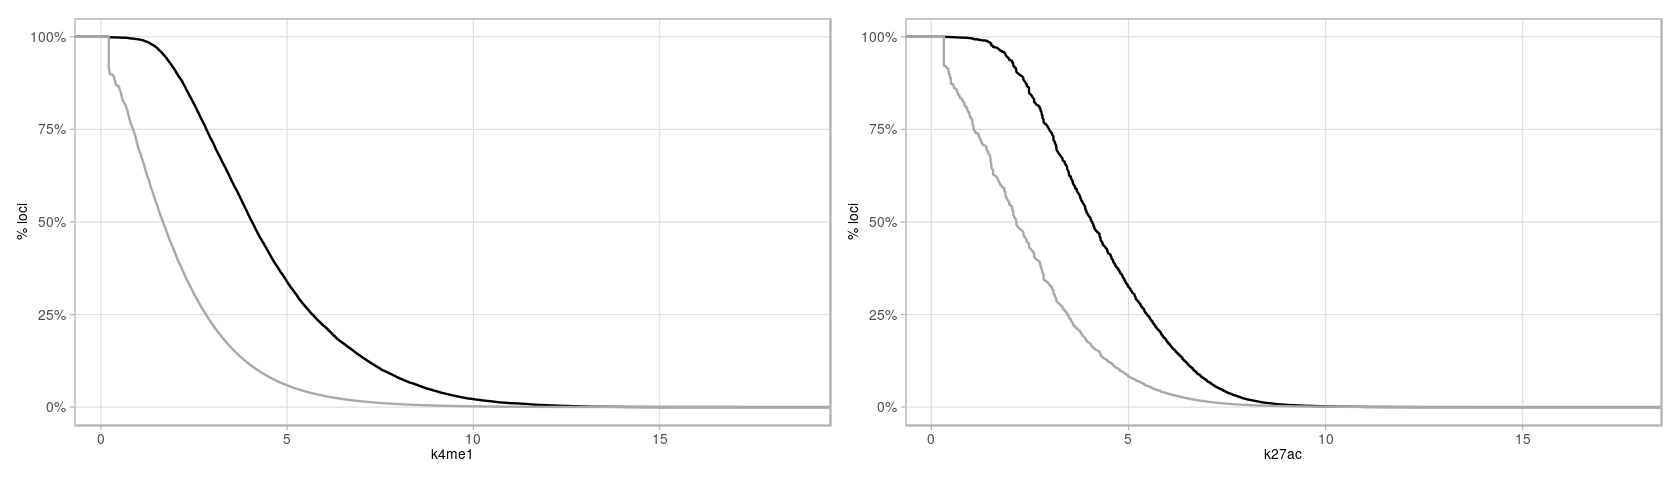

In [60]:
options(repr.plot.width=14, repr.plot.height=4)
p_k4me1 <- meth_dips_chip %>% 
    ggplot(aes(x=k4me1, y=1-..y..)) + 
        stat_ecdf() +             
        stat_ecdf(data = chip_bg, color = "darkgray") + 
        ylab("% loci") + 
        scale_y_continuous(label=scales::percent)         

p_k27ac <- meth_dips_chip %>% 
    ggplot(aes(x=k27ac, y=1-..y..)) + 
        stat_ecdf() +            
        stat_ecdf(data = chip_bg, color = "darkgray") + 
        ylab("% loci") + 
        scale_y_continuous(label=scales::percent)         


p_k4me1 + p_k27ac            

### Enhancer methylation distribution (Figure 5H, Figure S6G)

In [61]:
d_bg_comp <- extract_meth_at_context(bg_intervs, iterator = "intervs.global.seq_CG", min_cov = 10) %cache_df% here("output/dips_bg_meth_comp.tsv") %>% as_tibble()

In [62]:
d_bg_comp %>% filter(ctrl.cov >= 10, tet_tko.cov >= 10) %>% nrow()

[1] 12720

In [63]:
d_bg_comp %>% filter(e7.5.cov >= 10, tet_tko.cov >= 10) %>% nrow()

[1] 34185

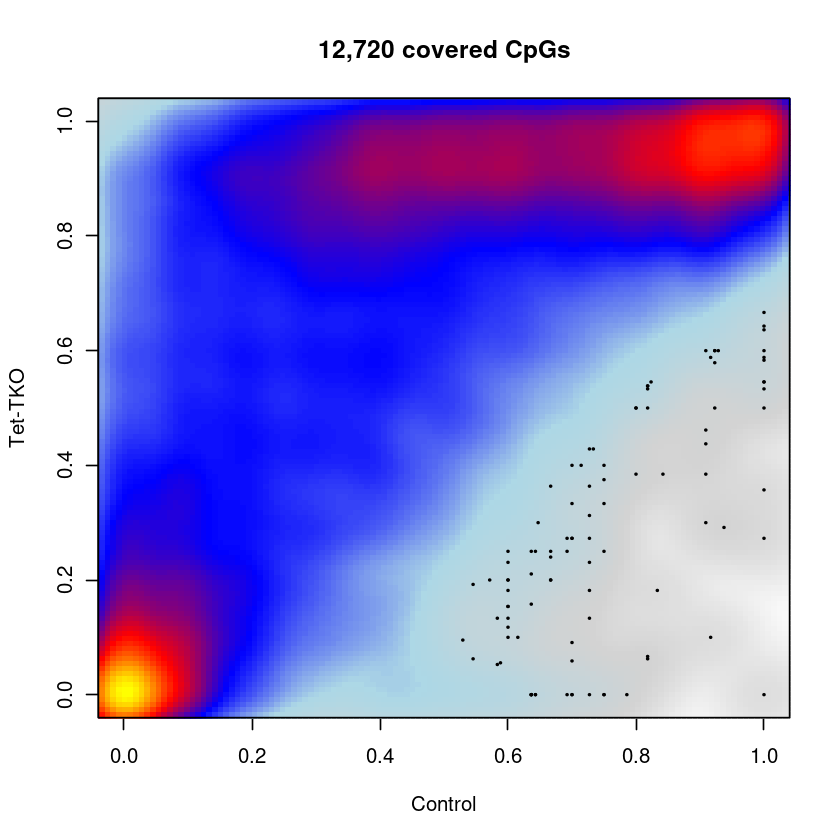

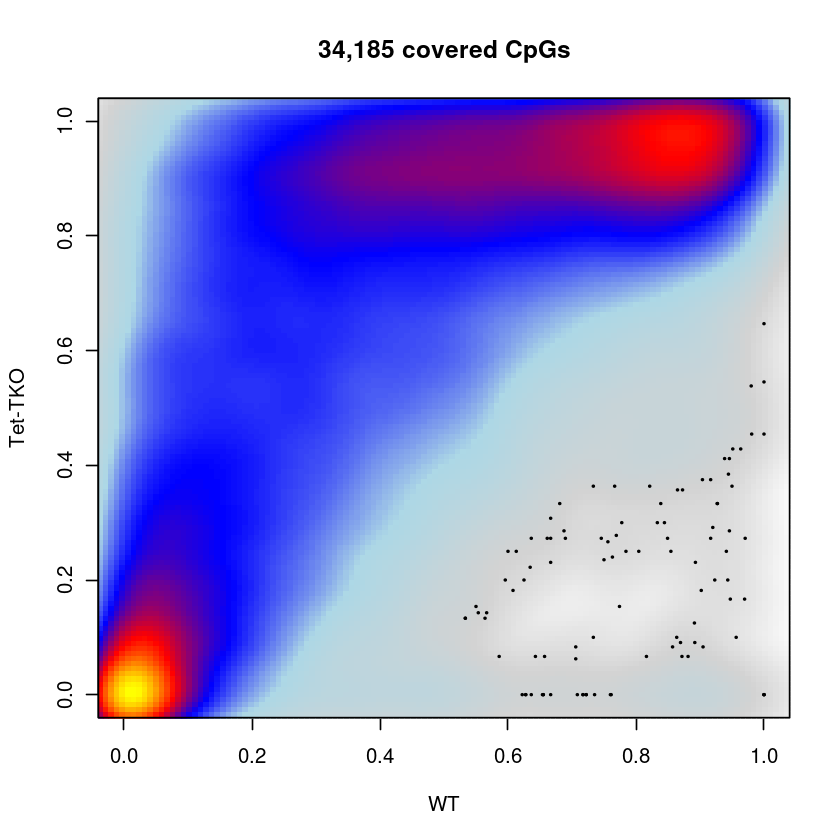

In [64]:
options(repr.plot.width = 7, repr.plot.height = 7)
min_cov <- 10
plot_smooth_cpg_scatter(d_bg_comp, "ctrl", "tet_tko", min_cov, "Control", "Tet-TKO", colors = c("white","lightgray","lightblue","blue", "red", "yellow"))
plot_smooth_cpg_scatter(d_bg_comp, "e7.5", "tet_tko", min_cov, "WT", "Tet-TKO", colors = c("white","lightgray","lightblue","blue", "red", "yellow"))

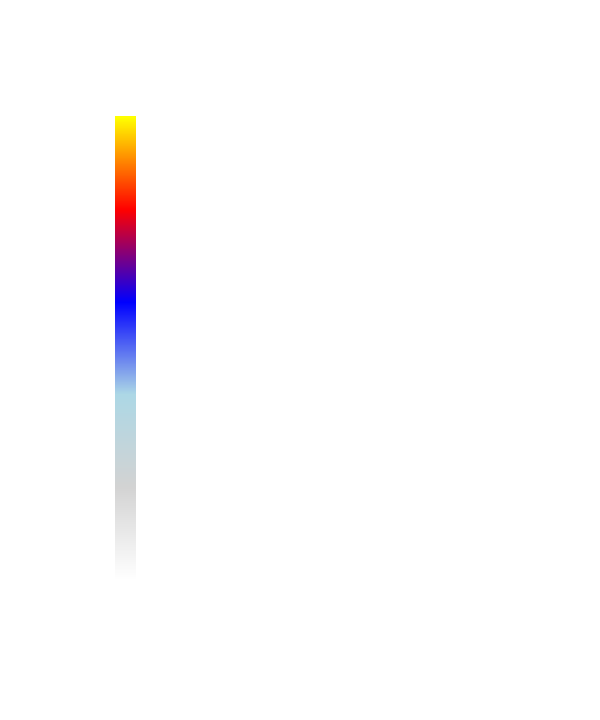

In [65]:
options(repr.plot.width = 5, repr.plot.height = 6)
plot_smooth_legend(c("white","lightgray","lightblue","blue", "red", "yellow"))

### Distribution of DNA methylation around the center of putative enhancers (Figure 5I)

In [68]:
df_dips_cpgs <- meth_df_comp_non_smoothed %>% 
    select(chrom:end, starts_with("ctrl"), starts_with("tet_tko")) %>% 
    gintervals.neighbors1(d_bg_comp %>% select(chrom, start, end, ctrl_dip=ctrl, wt_tet_tko=tet_tko) %>% mutate(strand = 1) %>% select(chrom, start, end, strand, everything()))

ctrl_dip,n
<fct>,<int>
"[0,0.3]",18815
"(0.3,0.7]",16067
"(0.7,1]",12567
NA,117473


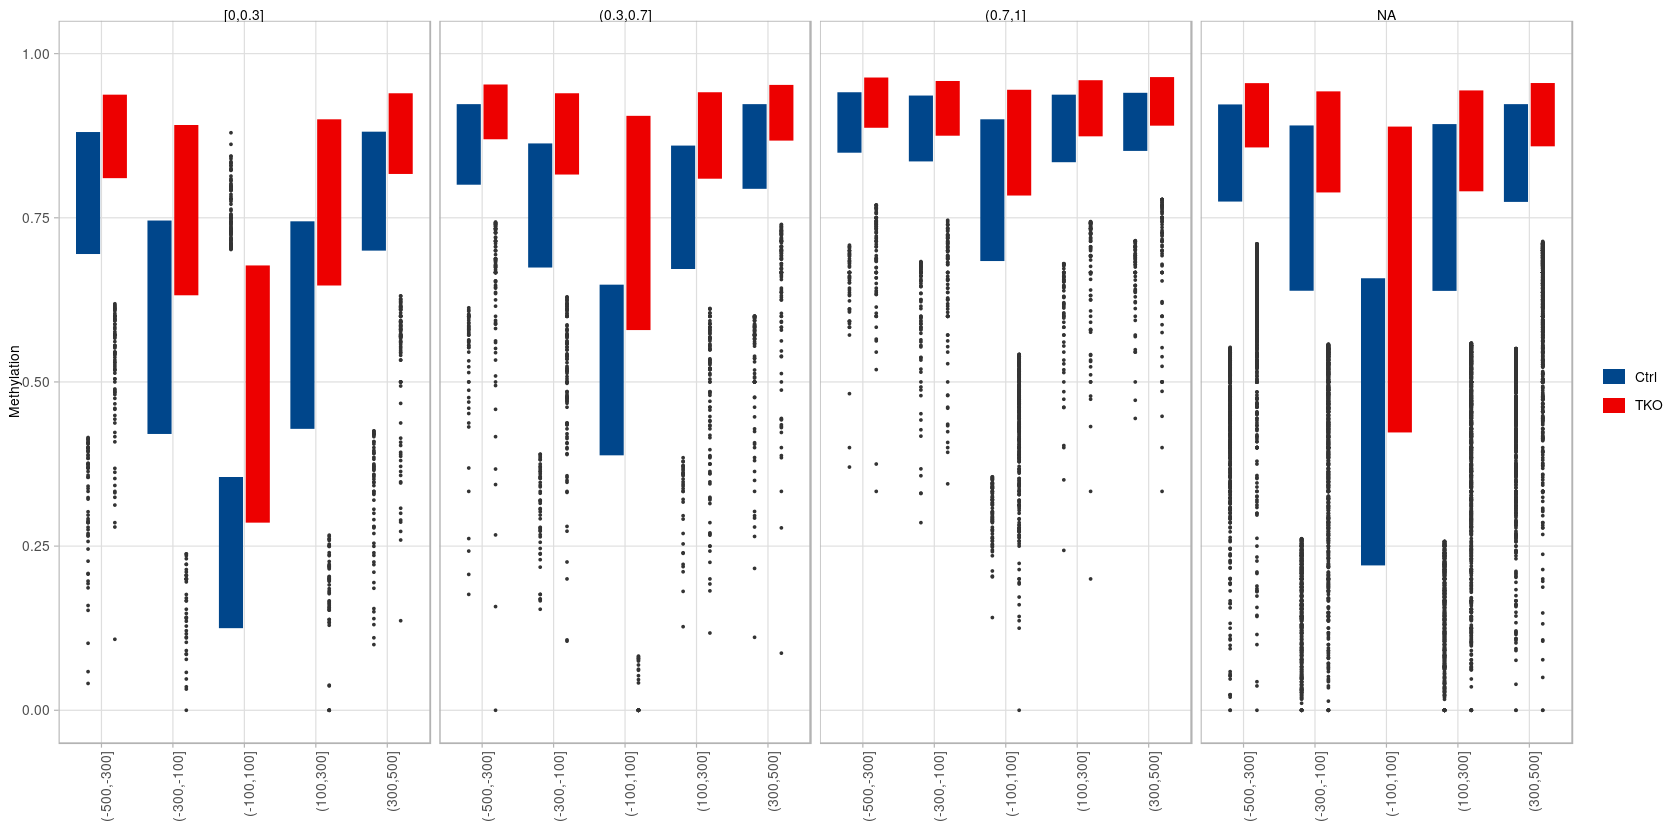

In [69]:
options(repr.plot.width=14, repr.plot.height=7)
df <- df_dips_cpgs %>%
    filter(abs(dist) <= 5e4) %>%
    mutate(dist = cut(dist, breaks=seq(-500, 500, length.out=6))) %>% 
    filter(!is.na(dist)) %>% 
    mutate(ctrl_dip = cut(ctrl_dip, c(0,0.3,0.7,1), include.lowest=TRUE)) %>% 
    group_by(chrom1, start1, end1, ctrl_dip, dist) %>% 
    summarise_at(vars(ends_with(".cov"), ends_with(".meth")), sum, na.rm=TRUE) %>% 
    ungroup() %>% 
    mutate(Ctrl= ctrl.meth / ctrl.cov, TKO = tet_tko.meth / tet_tko.cov) %>% 
    filter(ctrl.cov >= 10, tet_tko.cov >= 10)
df %>% count(ctrl_dip)
p_dips_boxp <-  df %>% 
    pivot_longer(Ctrl:TKO, names_to="type", values_to="meth") %>% 
    ggplot(aes(x=dist, y=meth, fill=type)) + 
        geom_boxplot(lwd = 0.01, outlier.size = 0.001, fatten = 0.1) + 
        facet_grid(.~ctrl_dip) +         
        scale_fill_manual(name="", values = c("Ctrl" = "#00468BFF", "TKO" = "#ED0000FF")) + 
        ylim(0,1) + 
        xlab("") + 
        ylab("Methylation") + 
        vertical_labs()
p_dips_boxp

In [70]:
df %>% 
    filter(dist == "(-100,100]") %>% 
    group_by(ctrl_dip) %>% 
    summarise_at(vars(Ctrl:TKO), mean, na.rm=TRUE) %>% 
    mutate(diff = TKO - Ctrl) %>% 
    mutate_at(vars(Ctrl:TKO), scales::percent)
    

df %>% 
    filter(dist == "(-100,100]") %>% 
    group_by(ctrl_dip) %>% 
    summarise(p = ks.test(Ctrl, TKO)$p.value)

ctrl_dip,Ctrl,TKO,diff
<fct>,<chr>,<chr>,<dbl>
"[0,0.3]",25.2%,48.7%,0.2350151
"(0.3,0.7]",51.7%,72.5%,0.2077952
"(0.7,1]",77.6%,84.2%,0.0659107
NA,44.4%,64.2%,0.1972279


Warning message in ks.test(Ctrl, TKO):
"p-value will be approximate in the presence of ties"
Warning message in ks.test(Ctrl, TKO):
"p-value will be approximate in the presence of ties"
Warning message in ks.test(Ctrl, TKO):
"p-value will be approximate in the presence of ties"
Warning message in ks.test(Ctrl, TKO):
"p-value will be approximate in the presence of ties"


ctrl_dip,p
<fct>,<dbl>
"[0,0.3]",0
"(0.3,0.7]",0
"(0.7,1]",0
NA,0


## Motifs (Figure S6H)

Due to the large size of the motif tracks, we provide here the script together with a pre-computed file:

In [71]:
dips_bg_expanded <- d_bg_comp %>% distinct(chrom, start, end) %>% mutate(start = start - 150, end = end + 150)
# motifs <- {
#     library(gpwm)
#     gpwm.extract_all("jolma_10bp", dips_bg_expanded, parallel=FALSE) 
#     }

motifs <- fread(here("data/dips_bg_expanded_motifs_jolma.tsv")) %>% as_tibble()

In [72]:
motifs_df <- motifs %>%
        gather("motif", "pwm", -(chrom:end)) %>%
        filter(grepl("di_DBD", motif)) %>%
        mutate(motif = gsub("jolma_10bp\\.", "", motif)) %>%
        mutate(motif = gsub("_di_DBD", "", motif)) %>%
        as_tibble()

In [73]:
motifs_df <- gextract_meth(comb_tracks, names = comb_names, min_cov = min_cov, intervals = motifs_df, iterator = motifs_df, join_intervals = TRUE) %>%
        select(-(chrom1:end1)) %>%
        rename(control = ctrl, control.cov = ctrl.cov)

Add global quantiles:

In [74]:
# global_quantiles <- gpwm.get_global_quantiles("jolma_10bp", size=10)
global_quantiles <- fread(here("data/motifs_global_quantiles.tsv")) %>% as_tibble()

In [75]:
motifs_df_thresh <- global_quantiles %>%
        filter(grepl("di_DBD", track)) %>%
        mutate(motif = gsub("_di_DBD", "", track)) %>%
        filter(quant == 0.995) %>%
        select(motif, thresh=value) %>%
        right_join(motifs_df) %>% 
        mutate(hit = pwm >= thresh)

Joining, by = "motif"


In [76]:
motifs_summary <- motifs_df_thresh %>%
        group_by(motif) %>%
        mutate(diff = tet_tko - control) %>%
        mutate(p.value = suppressWarnings(ks.test(diff[hit], diff[!hit])$p.value)) %>%
        group_by(motif, hit) %>%
        summarise(p.value = mean(p.value), n = n(), control = mean(control, na.rm=TRUE), tet_tko = mean(tet_tko, na.rm=TRUE)) %>%
        ungroup() %>%
        mutate(hit = ifelse(hit, "on", "off")) %>%
        pivot_wider(names_from = "hit", values_from = c("n", "control", "tet_tko")) %>%
        select(motif, n_off, control_off, tet_tko_off, n_on, control_on, tet_tko_on, `pval (of on diff vs off diff)` = p.value)  

### Table S3

In [77]:
writexl::write_xlsx(motifs_summary, here("output/motifs_summary.xlsx"))

In [78]:
motifs_to_plot <- c("POU2F3", "FOXJ3_4", "SOX11", "SOX1", "TCFAP2A", "IRX3", "SOX17", "HNF4A", "THRB", "FOXC1", "FOXC2", "MSX1")
motifs_to_plot <- map_chr(motifs_to_plot, ~ motifs_df_thresh %>% 
    distinct(motif) %>% 
    filter(grepl(.x, motif)) %>% 
    slice(1) %>% 
    pull(motif))
motifs_to_plot

[1] "POU2F3"    "FOXJ3_4"   "SOX11"     "SOX1_1"    "TCFAP2A_1" "IRX3"     
 [7] "SOX17_1"   "HNF4A_1"   "THRB_1"    "FOXC1_1"   "FOXC2_1"   "MSX1"

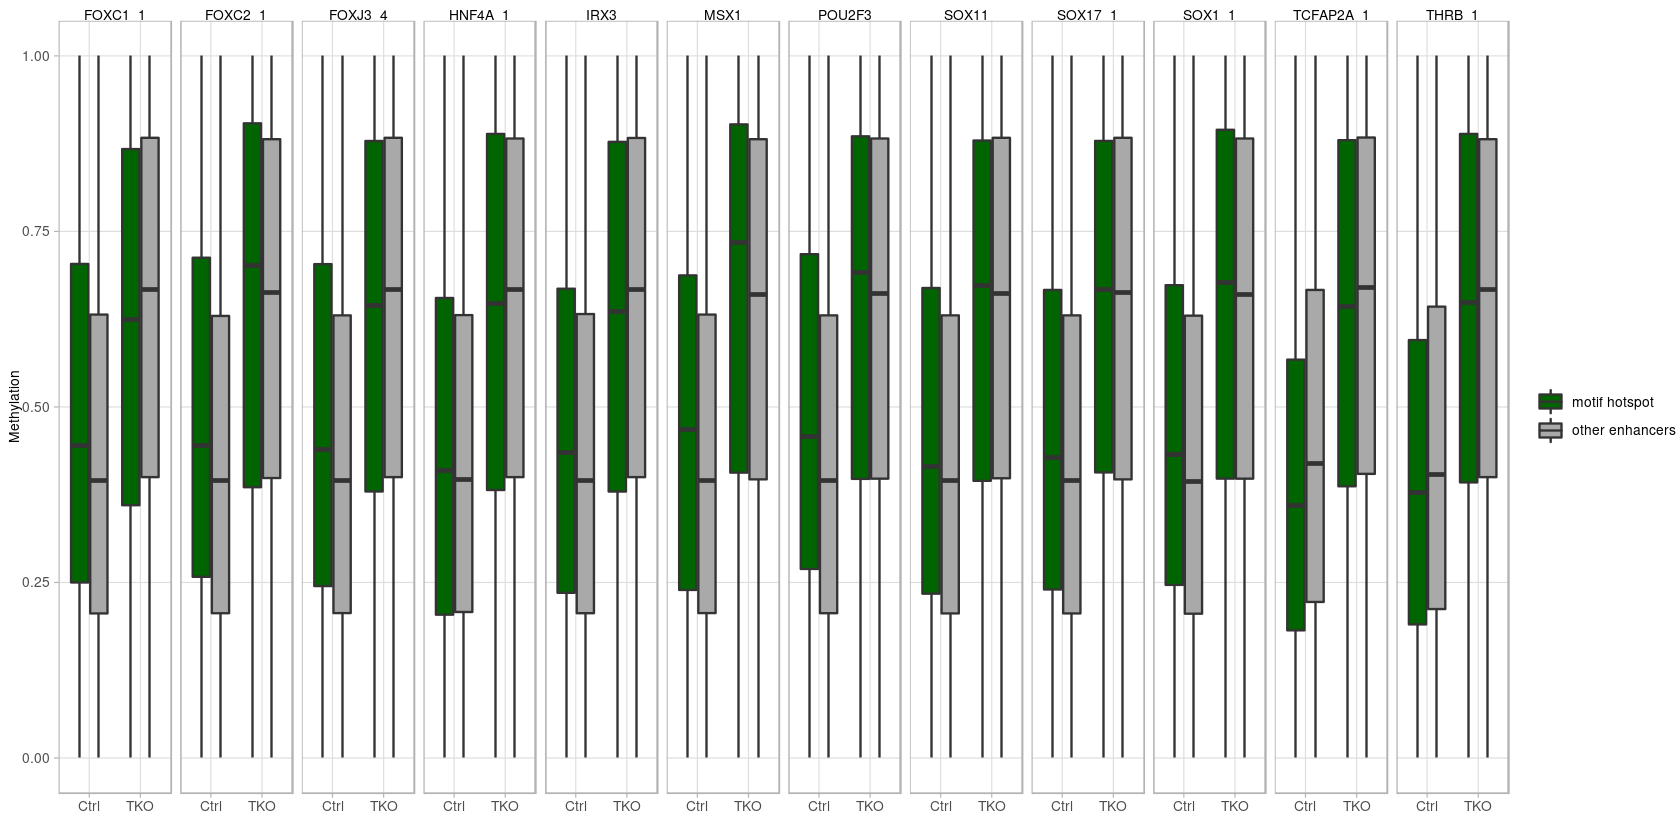

In [79]:
p_motifs_boxp <- motifs_df_thresh %>% 
    filter(motif %in% motifs_to_plot) %>% 
    select(-ends_with("cov")) %>%     
    rename(Ctrl = control, TKO = tet_tko) %>% 
    pivot_longer(names_to = "type", cols = c("Ctrl", "TKO"), values_to = "meth") %>% 
    mutate(hit = ifelse(hit, "motif hotspot", "other enhancers")) %>% 
    ggplot(aes(x=type, fill=hit, y=meth)) + 
        geom_boxplot() + 
        ylab("Methylation") + 
        xlab("") + 
        scale_fill_manual(name = "", values=rev(c("darkgray", "darkgreen"))) + 
        facet_grid(.~motif)
p_motifs_boxp